In [1]:
!pip install torch torchvision matplotlib numpy
!pip install wandb

### Import necessary Libraries

In [2]:
import json
import torch
import torch.nn as nn
import numpy as np
import wandb
from tqdm import tqdm
import pandas as pd
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score
import os
import gc

In [3]:
# Set environment variable for max_split_size_mb
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'

In [4]:
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

# Get the available devices
devices = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
print('number of available GPU: ',torch.cuda.device_count())  # Should print the number of visible devices

# Print the available devices
print("Available devices:")
for device in devices:
    print(f"- {device}")
device = torch.device("cuda:0")  # Use the first GPU

# Print the current device
#print(f"Current device: {torch.cuda.current_device()}")

number of available GPU:  1
Available devices:
- <torch.cuda.device object at 0x7f51ea022450>


In [5]:
torch.cuda.mem_get_info(device=device)

(4114481152, 8512602112)

In [6]:
!nvidia-smi

Fri Sep 20 21:58:48 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P4000        Off  | 00000000:65:00.0  On |                  N/A |
| 46%   39C    P0    31W / 105W |   4194MiB /  8118MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# Multiclass classification
#Predict if an asset will fail within two different intervals related to the two different decisions


`os`: This module provides functions for interacting with the operating system. It's commonly used for tasks such as file manipulation and directory operations.<br>
`sklearn.preprocessing`: This module from scikit-learn provides functions for preprocessing data, such as scaling, normalization, and encoding categorical variables.<br>
`sklearn.metrics`: This module contains functions for evaluating model performance, such as computing confusion matrices, recall scores, and precision scores.<br>
`multiclass_model_w1_30.h5`:The .h5 extension indicates that the model will be saved in the Hierarchical Data Format version 5 (HDF5) format, which is commonly used for storing large numerical datasets. The model will be saved with the filename **multiclass_model_w1_30.h5.**

In [8]:
# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score


# define path to save model
#model_path = 'multiclass_model_w1_30.h5'# This file then contains the already trained network, so that you don't have to retrain every time

## Data Ingestion


In [9]:
# read training data - It is the aircraft engine run-to-failure data.
from data_preprocessor import DataPreprocessor

# Initialize the preprocessor with the path to your training data file
preprocessor = DataPreprocessor('PM_train.txt')

`train_df.sort_values(['id','cycle'])`: This line sorts the DataFrame **train_df** first by the 'id' column and then by the 'cycle' column. It ensures that the data is ordered by engine ID and cycle number, which may be necessary for certain analyses or modeling tasks. The sorted DataFrame is then assigned back to the variable **train_df**.

## Data Preprocessing
data preprocessing step, particularly for labeling the data for training purposes. Let's break down what each part of the code does:


In [10]:
seq_array,dummy_label_array,seq_array_validation, dummy_label_array_validation,seq_array_test,dummy_label_array_test, sequence_cols = preprocessor.preprocess()
seq_array.shape, dummy_label_array.shape, seq_array_validation.shape, dummy_label_array_validation.shape,seq_array_test.shape, dummy_label_array_test.shape

((12138, 50, 25),
 (12138, 3),
 (1742, 50, 25),
 (1742, 3),
 (1751, 50, 25),
 (1751, 3))

In [11]:
print(sequence_cols)

['setting1', 'setting2', 'setting3', 'cycle_norm', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']


In [12]:
validation_df,test_df,train_df = preprocessor.test_data_pdmPolicy()
test_df.shape, train_df.shape, validation_df.shape

((2251, 29), (16138, 29), (2242, 29))

In [13]:
pdm_df = pd.concat([validation_df, test_df], ignore_index=True)
complete_df = pd.concat([train_df, pdm_df], ignore_index=True)
pdm_df.shape, pdm_df.columns

((4493, 29),
 Index(['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
        's15', 's16', 's17', 's18', 's19', 's20', 's21', 'RUL', 'label1',
        'label2'],
       dtype='object'))

In [14]:
pdm_df.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0  81      1   -0.0050    0.0003     100.0  518.67  642.04  1589.91  1406.63   
1  81      2    0.0023    0.0002     100.0  518.67  642.65  1586.25  1407.88   
2  81      3   -0.0005    0.0005     100.0  518.67  642.55  1586.42  1396.40   
3  81      4   -0.0001   -0.0000     100.0  518.67  642.41  1594.89  1404.86   
4  81      5    0.0024    0.0002     100.0  518.67  643.41  1590.49  1409.58   

      s5  ...     s15   s16  s17   s18    s19    s20      s21  RUL  label1  \
0  14.62  ...  8.4455  0.03  391  2388  100.0  38.87  23.3365  239       0   
1  14.62  ...  8.4573  0.03  392  2388  100.0  38.91  23.3452  238       0   
2  14.62  ...  8.4522  0.03  394  2388  100.0  39.04  23.3610  237       0   
3  14.62  ...  8.4403  0.03  392  2388  100.0  38.77  23.4206  236       0   
4  14.62  ...  8.3971  0.03  392  2388  100.0  39.04  23.3311  235       0   

   label2  
0       0  
1       0  
2       0  
3       0  
4       0  

[5 rows x 29 columns]

In [15]:
pdm_df['label2'].value_counts()

0    3873
1     400
2     220
Name: label2, dtype: int64

In [16]:
cols_normalize_train,cols_normalize_validation,cols_normalize_test = preprocessor.normalize_data_pdmPolicy()
cols_normalize_train

Index(['cycle_norm', 's1', 's10', 's11', 's12', 's13', 's14', 's15', 's16',
       's17', 's18', 's19', 's2', 's20', 's21', 's3', 's4', 's5', 's6', 's7',
       's8', 's9', 'setting1', 'setting2', 'setting3'],
      dtype='object')

>`Data Labeling`: This part calculates the Remaining Useful Life (RUL) or Time to Failure for each engine by finding the maximum cycle number (cycle) for each engine ID (id). The result is stored in a DataFrame rul with columns 'id' and 'max'.<br>

>`Merge RUL with Training Data`:the RUL information is merged back into the original training DataFrame **train_df** based on the engine ID. This allows each row in train_df to have the corresponding maximum cycle number as well.<br>

>`Calculate RUL`: This line calculates the RUL by subtracting the current cycle number ('cycle') from the maximum cycle number ('max') for each engine. This represents how many more cycles the engine is expected to operate before failure.<br>
>`Drop Unnecessary Columns`: After calculating RUL, the 'max' column, which was used temporarily to calculate RUL, is dropped from the DataFrame as it's no longer needed.<br>

> `Labeling for Classification`: This part assigns labels to each data point based on the calculated RUL. It defines thresholds `w1` and `w0`, and assigns:
>> * Label 1 ('label1') as 1 if RUL is less than or equal to 'w1', and 0 otherwise.
>> * Label2 ('label2') as 1 if RUL is less than or equal to 'w1', 2 if RUL is less than or equal to 'w0', and 0 otherwise.

 Now I want to separate the train_df set into a training/validation/test set. I will use 80% training sets for the training and 10% training sets as validation sets for hyperparameter tuning and the remaining 10% as test set for the PdM policy.

I separate into training and validation and test set before any data scaling is performed

Perform the min max scaling on the training data and validation dataset
use min_max_scaler.fit_transform()

>`Create a copy of the cycle column`: This line creates a new column named 'cycle_norm' in the train_df DataFrame and initializes it with the values from the original 'cycle' column. This column will be normalized later.<br>
> `Select columns for normalization`: This line selects all columns from **train_df** except 'id', 'cycle', 'RUL', 'label1', and 'label2'. These columns are the ones that will undergo normalization.


> `Initialize MinMaxScaler`: This line initializes a MinMaxScaler object from the scikit-learn preprocessing module. This scaler will be used to perform Min-Max normalization.<br>
> `Perform Min-Max normalization`: This line applies Min-Max normalization to the selected columns (`cols_normalize`) of the `train_df` DataFrame.<br>
> `min_max_scaler.fit_transform(train_df[cols_normalize])` computes the Min-Max normalization for the selected columns.<br>
> The resulting normalized values are stored in a new DataFrame called `norm_train_df`, with the same index as `train_df`.

> `Join normalized DataFrame with the original DataFrame`: This line joins the normalized DataFrame (`norm_train_df`) with the original DataFrame (`train_df`) excluding the columns that were normalized.<br>
> The resulting DataFrame `join_df` contains both the normalized columns and the original columns that were not normalized.


`Reorder columns`:
> * This line reorders the columns of `join_df` to match the original order of columns in `train_df`.
> * The reordered DataFrame is then assigned back to `train_df`, effectively replacing the original DataFrame with the normalized version.






## Vanilla Transformer

When you use `sequence_cols.extend(sensor_cols)`, it adds each element of `sensor_cols` to the end of `sequence_cols`.<br>
After this operation, `sequence_cols` will contain 25 elements: 4 operational settings followed by 21 sensor readings.



## generate sequences for each engine
> * This creates a generator expression that iterates over unique engine IDs in the training data.<br>
> * For each engine, it generates sequences using the `gen_sequence` function defined earlier.<br>
> * Each sequence is a list of sensor data, and multiple sequences are generated for each engine.<br>



> * This concatenates all the generated sequences into a single numpy array.
> * It converts the array to `float32` data type.
> * The resulting `seq_array` contains the sequences of sensor data, with shape `(num_sequences, sequence_length, num_features)`.


In [17]:
# we always take the measurements of the last 50 cycles as input!
# Every sequence is reduced by a length of 50 (=sequence_length). We have 80 training sets, 80*50 = 4000 "less" inputs
# train_df.shape = (16138, 30)
# seq_array.shape = (12138, 50, 25)

`Function Signature:` This function efficiently generates labels for each sequence of sensor data. It ensures that the labels are correctly aligned with the sequences and handles the special case where the first sequence uses the last label as its target.





> This function takes three arguments:
>> * `id_df:` DataFrame containing data for a specific engine (id).<br>
>> * `seq_length`: Length of the sequence window.<br>
>> * `label`: List of column names representing the labels.

`Data Preparation:`
> * `data_matrix = id_df[label].values:`
>> * This line extracts the columns specified by label from the DataFrame id_df and converts them to a numpy array.<br>
>> * It selects only the relevant label(s) needed for generating sequences.<br>

`Label Generation:`
> * `num_elements:`This line calculates the number of rows (elements) in the data matrix, which corresponds to the number of labels.<br>
> * `return data_matrix[seq_length:num_elements, :]:`
>> * This line returns the labels associated with each sequence.<br>
>> * It removes the first `seq_length` labels because, for each engine (`id`), the first sequence of size `seq_length` uses the last label as its target. The previous labels are discarded.<br>
>> * All subsequent sequences for the same engine (`id`) will have one label associated with them step by step.<br>








When modeling multi-class classification problems using neural networks,<br>
it is good practice to reshape the output attribute from a vector that contains values for each class value to be<br>
a matrix with a boolean for each class value and whether or not a given instance has that class value or not.<br>
This is called one hot encoding or creating dummy variables from a categorical variable.<br>

from tensorflow.keras.utils import to_categorical<br>

`to_categorical` is a utility function in Keras that converts class vectors (integers) to binary class matrices.<br>
`dummy_label_array = to_categorical(label_array):`This line applies one-hot encoding to the `label_array`.<br>
`label_array` contains the labels associated with each sequence, where each label represents a class or category.<br>
> * One-hot encoding converts these integer labels into binary vectors, where each vector has a length equal to the number of classes and contains a 1 in the position corresponding to the class and 0s elsewhere.





In [18]:
dummy_label_array

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [19]:
dummy_label_array_validation

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [20]:
dummy_label_array_validation.shape

(1742, 3)

In [21]:
dummy_label_array.shape

(12138, 3)

In [22]:
nb_features = seq_array.shape[2]
nb_out      = dummy_label_array.shape[1]
nb_features, nb_out

(25, 3)

`Extracting Feature and Output Dimensions:`
> `nb_features:`Determines the number of features in the input sequence data.<br>
> `nb_out:`Determines the number of output classes. It's extracted from the shape of the label array.<br>

`Defining the Model Architecture:` describe in the code below.
`Compiling the Model:` `model.compile(...)` Here, `categorical_crossentropy` is used as the loss function for multi-class classification.

`Model Summary:`Prints a summary of the model architecture, including the layers and their parameters.

`Training the Model:` `model.fit(...):` Trains the model on the training data. It specifies the input data (`seq_array`) and the corresponding labels (`dummy_label_array`). Other parameters include the number of epochs, batch size, validation split, verbosity, and callbacks.<br>


`history.history.keys():` After training, this prints the keys of the history object, which contains information about training and validation metrics over each epoch.



### Define the Dataset:
Create a custom dataset class to handle your multivariate time series data with labels.




In [23]:
#from google.colab import drive
#drive.mount('/content/drive')

#import os
#os.chdir('/content/drive/MyDrive/Colab Notebooks/LSTM_Antonis')

`Shuffling Batches:` By setting `shuffle=True` in the `DataLoader` for the training set, you ensure that the order of batches is shuffled each epoch. This maintains the temporal structure within each batch while still introducing variability in the order in which batches are processed.<br>

`DataLoader for Validation:` Ensure `shuffle=False` for the validation set to maintain the sequence order during validation.

In [24]:
# Import custom classes
import torch
from torch.utils.data import TensorDataset, DataLoader

from dataset import MultivariateTimeSeriesDataset
from model import TransformerTimeSeriesModel

# Load initial parameters from params.json
with open('params.json', 'r') as f:
    params = json.load(f)

# Load hyperparameter search space from hyperparameters.json
with open('hyperparameters.json', 'r') as f:
    hp_config = json.load(f)
    


# Example usage with seq_array and dummy_var
#seq_array --> (12138, 50, 25)  # use this as your actual data
#dummy_var --->  (12138, 3) # use this as your actual dummy variable (3 classes)

#train_dataset = MultivariateTimeSeriesDataset(seq_array, dummy_label_array, params['seq_length'])
#val_dataset = MultivariateTimeSeriesDataset(seq_array_validation, dummy_label_array_validation, params['seq_length'])

# Shuffle batches by setting shuffle=True in DataLoader
#train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)


In [25]:
"""
os.environ['WANDB_API_KEY'] = 'f05e720396a77affdb7e82b525ef1a912da7aaf4'

try:
    wandb.login()
    print(f"Successfully logged in as: {wandb.api.viewer()['entity']}")
except wandb.errors.AuthenticationError:
    print("Failed to authenticate. Please check your API key.")
"""


'\nos.environ[\'WANDB_API_KEY\'] = \'f05e720396a77affdb7e82b525ef1a912da7aaf4\'\n\ntry:\n    wandb.login()\n    print(f"Successfully logged in as: {wandb.api.viewer()[\'entity\']}")\nexcept wandb.errors.AuthenticationError:\n    print("Failed to authenticate. Please check your API key.")\n'

In [26]:
"""
current_entity = wandb.api.viewer()['entity']
print(f"Currently logged in as: {current_entity}")
if current_entity != "jitendratiwari11":
    raise ValueError(f"Logged in as {current_entity}, but expected to be logged in as jitendra")

print(wandb.api.viewer()['entity'])
"""

'\ncurrent_entity = wandb.api.viewer()[\'entity\']\nprint(f"Currently logged in as: {current_entity}")\nif current_entity != "jitendratiwari11":\n    raise ValueError(f"Logged in as {current_entity}, but expected to be logged in as jitendra")\n\nprint(wandb.api.viewer()[\'entity\'])\n'

In [27]:
#wandb.finish()

In [28]:
#print(wandb.config)

### Define the Transformer Model:
Implement the vanilla Transformer architecture, ensuring it takes the dummy variable as an input.



### Training the model

Define the training loop with the loss function and optimizer, and include the dummy variable in the forward pass.



In [29]:
"""
def train_and_evaluate(config, num_epochs,use_early_stopping=True):
    model = TransformerTimeSeriesModel(
        input_dim=params['input_dim'],
        seq_length=params['seq_length'],
        num_classes=params['num_classes'],
        model_dim=config['model_dim'],
        num_heads=config['num_heads'],
        num_layers=config['num_layers'],
        dropout_rate=config['dropout_rate']
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    scaler = GradScaler()

    # Set up datasets
    train_dataset = MultivariateTimeSeriesDataset(seq_array, dummy_label_array, params['seq_length'])
    val_dataset = MultivariateTimeSeriesDataset(seq_array_validation, dummy_label_array_validation, params['seq_length'])

    # Set up data loaders
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    
    train_losses = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    best_val_accuracy = 0
    best_accuracy = 0
    best_model = None
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for i, batch in enumerate(train_pbar):
            inputs, labels = batch
            inputs, labels = inputs.float().to(device), labels.float().to(device)
            
            with autocast():
                outputs_class = model(inputs)
                outputs_reshaped = outputs_class.view(-1, model.num_classes)
                labels_reshaped = labels.view(-1, model.num_classes).argmax(dim=1)
                loss = criterion(outputs_reshaped, labels_reshaped) / config['gradient_accumulation_steps']

            scaler.scale(loss).backward()
            
            if (i + 1) % config['gradient_accumulation_steps'] == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            total_train_loss += loss.item() * config['gradient_accumulation_steps']
            
            
            current_train_loss = total_train_loss / (i + 1)
            train_pbar.set_postfix({'train loss': current_train_loss})
            
            if i % 100 == 0:
                torch.cuda.empty_cache()
                gc.collect()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        
        #Validation loop
        model.eval()
        total_val_loss = 0.0
        all_preds = []
        all_labels = []

        
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for batch in val_pbar:
                inputs, labels = batch
                inputs, labels = inputs.float().to(device), labels.float().to(device)
                
                with autocast():
                    outputs_class = model(inputs)
                    outputs_reshaped = outputs_class.view(-1, model.num_classes)
                    labels_reshaped = labels.view(-1, model.num_classes).argmax(dim=1)
                    val_loss = criterion(outputs_reshaped, labels_reshaped)
                
                total_val_loss += val_loss.item()

                _, preds = torch.max(outputs_class, dim=2)
                all_preds.extend(preds.cpu().numpy().reshape(-1))
                all_labels.extend(labels.argmax(dim=2).cpu().numpy().reshape(-1))

                current_val_loss = total_val_loss / (val_pbar.n + 1)
                val_pbar.set_postfix({'val loss': current_val_loss})

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Val Accuracy: {accuracy:.2f}%")
        
        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_accuracy": accuracy
        })
        if use_early_stopping:
            # Early stopping check
            if accuracy > best_val_accuracy:
                best_val_accuracy = accuracy
                best_val_loss = avg_val_loss
                best_model = model.state_dict()
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= params['patience']:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
        else:
            # If not using early stopping, always update best model
            best_val_accuracy = accuracy
            best_val_loss = avg_val_loss
            best_model = model.state_dict()
            

        
        torch.cuda.empty_cache()
        gc.collect()

    #Load the best model before returning
    model.load_state_dict(best_model)

    return model, train_losses, val_losses, val_accuracies
"""

'\ndef train_and_evaluate(config, num_epochs,use_early_stopping=True):\n    model = TransformerTimeSeriesModel(\n        input_dim=params[\'input_dim\'],\n        seq_length=params[\'seq_length\'],\n        num_classes=params[\'num_classes\'],\n        model_dim=config[\'model_dim\'],\n        num_heads=config[\'num_heads\'],\n        num_layers=config[\'num_layers\'],\n        dropout_rate=config[\'dropout_rate\']\n    )\n\n    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n    model.to(device)\n    \n    criterion = nn.CrossEntropyLoss()\n    optimizer = optim.AdamW(model.parameters(), lr=config[\'learning_rate\'], weight_decay=config[\'weight_decay\'])\n    scaler = GradScaler()\n\n    # Set up datasets\n    train_dataset = MultivariateTimeSeriesDataset(seq_array, dummy_label_array, params[\'seq_length\'])\n    val_dataset = MultivariateTimeSeriesDataset(seq_array_validation, dummy_label_array_validation, params[\'seq_length\'])\n\n    # Set up data loaders\n

In [30]:

"""
def objective():
    global trial_counter
    with wandb.init() as run:
        config = wandb.config
        best_model, train_losses, val_losses, val_accuracies = train_and_evaluate(config, num_epochs=config.num_epochs)
        
        best_val_accuracy = max(val_accuracies)
        wandb.log({"best_val_accuracy": best_val_accuracy})
        
        trial_counter = run.step + 1
        print(f"Trial {trial_counter}/{hp_config['num_trials']}, "
              f"Best Val Accuracy: {best_val_accuracy:.2f}")

        
        # Save the best model
        #torch.save(best_model.state_dict(), 'best_model_3_class.pth')
        #wandb.save('best_model_3_class.pth')
        
        return best_val_accuracy

"""


'\ndef objective():\n    global trial_counter\n    with wandb.init() as run:\n        config = wandb.config\n        best_model, train_losses, val_losses, val_accuracies = train_and_evaluate(config, num_epochs=config.num_epochs)\n        \n        best_val_accuracy = max(val_accuracies)\n        wandb.log({"best_val_accuracy": best_val_accuracy})\n        \n        trial_counter = run.step + 1\n        print(f"Trial {trial_counter}/{hp_config[\'num_trials\']}, "\n              f"Best Val Accuracy: {best_val_accuracy:.2f}")\n\n        \n        # Save the best model\n        #torch.save(best_model.state_dict(), \'best_model_3_class.pth\')\n        #wandb.save(\'best_model_3_class.pth\')\n        \n        return best_val_accuracy\n\n'

In [31]:
"""

# Define the hyperparameter search space
sweep_config = {
    'method': hp_config['method'],
    'metric': {'name': hp_config['metric_name'], 'goal': hp_config['metric_goal']},
    'parameters': {
        'model_dim': {'values': hp_config['model_dim']},
        'num_heads': {'values': hp_config['num_heads']},
        'num_layers': {'values': hp_config['num_layers']},
        'dropout_rate': {'distribution': 'uniform', 'min': hp_config['dropout_rate']['min'], 'max': hp_config['dropout_rate']['max']},
        'learning_rate': {'distribution': 'log_uniform_values', 'min': hp_config['learning_rate']['min'], 'max': hp_config['learning_rate']['max']},
        'batch_size': {'values': hp_config['batch_size']},
        'num_epochs': {'values': hp_config['num_epochs']},
        'weight_decay': {'distribution': 'log_uniform_values', 'min': hp_config['weight_decay']['min'], 'max': hp_config['weight_decay']['max']},
        'gradient_accumulation_steps': {'values': hp_config['gradient_accumulation_steps']}
    }
}


# sweep_id = wandb.sweep(sweep_config, project="transformer_time_series", entity="jitendratiwari11")
sweep_id= 'c3hgzsib'
# Start the sweep
#wandb.agent(sweep_id, function=objective, count=hp_config['num_trials'])
wandb.agent(sweep_id, function=objective, count=hp_config['num_trials'], project="transformer_time_series", entity="jitendratiwari11")

# After all trials, find the best run
api = wandb.Api()
runs = api.runs("jitendratiwari11/transformer_time_series")
best_run = max(runs, key=lambda run: run.summary.get('best_val_accuracy', 0))

print(f"Best run: {best_run.name}")
print(f"Best validation accuracy: {best_run.summary['best_val_accuracy']}")
print("Best parameters:")
print(json.dumps(best_run.config, indent=4))

# Update params.json with best parameters
params.update(best_run.config)
with open('params.json', 'w') as f:
    json.dump(params, f, indent=4)

print("Best parameters saved to params.json")

# # Run the best model for longer epochs
# print("Running best model for longer epochs...")
# wandb.init(project="transformer_time_series", name="best_model_long_run", config=params, reinit=True)

# best_model, train_losses, val_losses, val_accuracies = train_and_evaluate(params, num_epochs=1000)
"""

'\n\n# Define the hyperparameter search space\nsweep_config = {\n    \'method\': hp_config[\'method\'],\n    \'metric\': {\'name\': hp_config[\'metric_name\'], \'goal\': hp_config[\'metric_goal\']},\n    \'parameters\': {\n        \'model_dim\': {\'values\': hp_config[\'model_dim\']},\n        \'num_heads\': {\'values\': hp_config[\'num_heads\']},\n        \'num_layers\': {\'values\': hp_config[\'num_layers\']},\n        \'dropout_rate\': {\'distribution\': \'uniform\', \'min\': hp_config[\'dropout_rate\'][\'min\'], \'max\': hp_config[\'dropout_rate\'][\'max\']},\n        \'learning_rate\': {\'distribution\': \'log_uniform_values\', \'min\': hp_config[\'learning_rate\'][\'min\'], \'max\': hp_config[\'learning_rate\'][\'max\']},\n        \'batch_size\': {\'values\': hp_config[\'batch_size\']},\n        \'num_epochs\': {\'values\': hp_config[\'num_epochs\']},\n        \'weight_decay\': {\'distribution\': \'log_uniform_values\', \'min\': hp_config[\'weight_decay\'][\'min\'], \'max\': hp_c

In [32]:
"""
# Run the best model for longer epochs
print("Running best model for longer epochs...")
wandb.init(project="transformer_time_series", name="experiment200", config=params, reinit=True)

best_model, train_losses, val_losses, val_accuracies = train_and_evaluate(params, num_epochs=200, use_early_stopping=True)

# Save the model after 1000 epochs
torch.save(best_model.state_dict(), 'best_model_after_200_epochs.pth')
print("Model after 200 epochs saved to best_model_after_200_epochs.pth")
"""


'\n# Run the best model for longer epochs\nprint("Running best model for longer epochs...")\nwandb.init(project="transformer_time_series", name="experiment200", config=params, reinit=True)\n\nbest_model, train_losses, val_losses, val_accuracies = train_and_evaluate(params, num_epochs=200, use_early_stopping=True)\n\n# Save the model after 1000 epochs\ntorch.save(best_model.state_dict(), \'best_model_after_200_epochs.pth\')\nprint("Model after 200 epochs saved to best_model_after_200_epochs.pth")\n'

## Model Evaluation on Validation set created during preprocessing of data

In [33]:
"""
# Plot the losses and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.savefig('learning_curves_100_epochs.png')
plt.close()

wandb.log({
    "final_train_loss": train_losses[-1],
    "final_val_loss": val_losses[-1],
    "final_val_accuracy": val_accuracies[-1],
    "training_curves": wandb.Image('training_curves.png')
})

print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")
print(f"Final validation accuracy: {val_accuracies[-1]:.2f}%")

wandb.finish()
"""


'\n# Plot the losses and accuracy\nplt.figure(figsize=(12, 4))\nplt.subplot(1, 2, 1)\nplt.plot(train_losses, label=\'Train Loss\')\nplt.plot(val_losses, label=\'Validation Loss\')\nplt.xlabel(\'Epoch\')\nplt.ylabel(\'Loss\')\nplt.legend()\nplt.title(\'Training and Validation Loss\')\n\nplt.subplot(1, 2, 2)\nplt.plot(val_accuracies, label=\'Validation Accuracy\')\nplt.xlabel(\'Epoch\')\nplt.ylabel(\'Accuracy (%)\')\nplt.legend()\nplt.title(\'Validation Accuracy\')\n\nplt.tight_layout()\nplt.savefig(\'learning_curves_100_epochs.png\')\nplt.close()\n\nwandb.log({\n    "final_train_loss": train_losses[-1],\n    "final_val_loss": val_losses[-1],\n    "final_val_accuracy": val_accuracies[-1],\n    "training_curves": wandb.Image(\'training_curves.png\')\n})\n\nprint(f"Final train loss: {train_losses[-1]:.4f}")\nprint(f"Final validation loss: {val_losses[-1]:.4f}")\nprint(f"Final validation accuracy: {val_accuracies[-1]:.2f}%")\n\nwandb.finish()\n'

In [34]:
#print(f" total nr of parameters as per best model: {sum(p.numel() for p in best_model.parameters() if p.requires_grad)}")

In [35]:
import torch
print(torch.version.cuda)

11.7


In [36]:
#torch.cuda.empty_cache()
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [37]:
#device = torch.device("cpu")
#estimator = estimator.to(device)

## Confusion matrix and Classification report

For each test set, I need to give the on-line sensor data as input to the trained Transformer.


In [38]:
import numpy as np
import torch
from model import TransformerTimeSeriesModel
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score, r2_score
from torch.utils.data import DataLoader

def custom_collate(batch):
    inputs = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    
    inputs = torch.tensor(np.array(inputs), dtype=torch.float32)
    labels = torch.tensor(np.array(labels), dtype=torch.long)
    
    return inputs, labels

def custom_classification_report(y_true, y_pred, y_prob):
    classes = np.unique(y_true)
    report = {}
    
    for cls in classes:
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        prob_cls = y_prob[:, cls]
        
        f1 = f1_score(true_cls, pred_cls, average='binary')
        f2 = fbeta_score(true_cls, pred_cls, beta=2, average='binary')
        r2 = r2_score(true_cls.astype(int), prob_cls)
        
        report[cls] = {
            'F1-score': f1,
            'F2-score': f2,
            'R2-score': r2
        }
    
    # Calculate macro average
    macro_f1 = np.mean([report[cls]['F1-score'] for cls in classes])
    macro_f2 = np.mean([report[cls]['F2-score'] for cls in classes])
    macro_r2 = np.mean([report[cls]['R2-score'] for cls in classes])
    
    report['macro avg'] = {
        'F1-score': macro_f1,
        'F2-score': macro_f2,
        'R2-score': macro_r2
    }
    
    return report

model_path = 'best_model_after_200_epochs.pth'

if os.path.isfile(model_path):
    estimator = TransformerTimeSeriesModel(
        input_dim=params['input_dim'],
        seq_length=params['seq_length'],
        num_classes=params['num_classes'],
        model_dim=params['model_dim'],
        num_heads=params['num_heads'],
        num_layers=params['num_layers'],
        dropout_rate=params['dropout_rate']
    )

    estimator.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    
    print(f"Model loaded from {model_path}")
    print(f"Total nr of parameters: {sum(p.numel() for p in estimator.parameters() if p.requires_grad)}")
    
    device = torch.device("cpu")
    estimator = estimator.to(device)
    estimator.eval()

    test_dataset = MultivariateTimeSeriesDataset(seq_array_test, dummy_label_array_test, params['seq_length'])
    
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate)
    
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = estimator(inputs)
            probs = torch.softmax(outputs, dim=2)

            _, preds = torch.max(outputs, dim=2)
            all_preds.extend(preds.cpu().numpy().reshape(-1))
            all_labels.extend(labels.argmax(dim=2).cpu().numpy().reshape(-1))
            all_probs.extend(probs.cpu().numpy().reshape(-1, params['num_classes']))
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Custom classification report
    report = custom_classification_report(all_labels, all_preds, all_probs)
    print("\nCustom Classification Report:")
    for cls in report:
        print(f"Class {cls}:")
        for metric, value in report[cls].items():
            print(f"  {metric}: {value:.4f}")
        print()

else:
    print(f"No saved model found at {model_path}")

Model loaded from best_model_after_200_epochs.pth
Total nr of parameters: 88163
Confusion Matrix:
[[72000    50     0]
 [ 2950  7050     0]
 [    0  1039  4461]]

Custom Classification Report:
Class 0:
  F1-score: 0.9796
  F2-score: 0.9913
  R2-score: 0.7975

Class 1:
  F1-score: 0.7773
  F2-score: 0.7323
  R2-score: 0.6163

Class 2:
  F1-score: 0.8957
  F2-score: 0.8429
  R2-score: 0.8423

Class macro avg:
  F1-score: 0.8842
  F2-score: 0.8555
  R2-score: 0.7520



In [39]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix, r2_score, fbeta_score
from sklearn.preprocessing import label_binarize

def evaluate_multiclass_model(y_true, y_pred, y_prob):
    # Compute precision, recall, and F1 score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    
    # Compute ROC AUC for each class
    n_classes = y_prob.shape[1]
    y_bin = label_binarize(y_true, classes=range(n_classes))
    roc_auc = []
    for i in range(n_classes):
        roc_auc.append(roc_auc_score(y_bin[:, i], y_prob[:, i]))
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Compute class-specific accuracy
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    
    # Compute R2 score for each class
    r2_scores = []
    for i in range(y_prob.shape[1]):
        r2 = r2_score((y_true == i).astype(int), y_prob[:, i])
        r2_scores.append(r2)
    
    # Compute F2 score for each class
    f2_scores = []
    for i in range(y_prob.shape[1]):
        f2 = fbeta_score((y_true == i).astype(int), (y_pred == i).astype(int), beta=2)
        f2_scores.append(f2)
    
    # Create a dictionary to store all metrics
    metrics = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'class_accuracy': class_accuracy,
        'r2_score': r2_scores,
        'f2_score': f2_scores,
        'confusion_matrix': cm
    }
    
    return metrics

# After your model prediction
metrics = evaluate_multiclass_model(all_labels, all_preds, all_probs)

# Print or visualize the results
class_names = ['Class 0', 'Class 1', 'Class 2']  # Replace with your actual class names
for i, class_name in enumerate(class_names):
    print(f"Metrics for {class_name}:")
    print(f"Precision: {metrics['precision'][i]:.4f}")
    print(f"Recall: {metrics['recall'][i]:.4f}")
    print(f"F1-score: {metrics['f1_score'][i]:.4f}")
    print(f"ROC AUC: {metrics['roc_auc'][i]:.4f}")
    print(f"Accuracy: {metrics['class_accuracy'][i]:.4f}")
    print(f"R2 Score: {metrics['r2_score'][i]:.4f}")
    print(f"F2 Score: {metrics['f2_score'][i]:.4f}")
    print("---")

print("Confusion Matrix:")
print(metrics['confusion_matrix'])

Metrics for Class 0:
Precision: 0.9606
Recall: 0.9993
F1-score: 0.9796
ROC AUC: 0.9973
Accuracy: 0.9993
R2 Score: 0.7975
F2 Score: 0.9913
---
Metrics for Class 1:
Precision: 0.8662
Recall: 0.7050
F1-score: 0.7773
ROC AUC: 0.9831
Accuracy: 0.7050
R2 Score: 0.6163
F2 Score: 0.7323
---
Metrics for Class 2:
Precision: 1.0000
Recall: 0.8111
F1-score: 0.8957
ROC AUC: 0.9985
Accuracy: 0.8111
R2 Score: 0.8423
F2 Score: 0.8429
---
Confusion Matrix:
[[72000    50     0]
 [ 2950  7050     0]
 [    0  1039  4461]]


In [40]:
import numpy as np
import torch
from model import TransformerTimeSeriesModel
from sklearn.metrics import confusion_matrix, classification_report, r2_score, fbeta_score
from torch.utils.data import DataLoader

def custom_collate(batch):
    inputs = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    
    # Convert numpy arrays to PyTorch tensors
    inputs = torch.tensor(np.array(inputs), dtype=torch.float32)
    labels = torch.tensor(np.array(labels), dtype=torch.long)
    
    return inputs, labels

model_path = 'best_model_after_200_epochs.pth'

if os.path.isfile(model_path):
    estimator = TransformerTimeSeriesModel(
        input_dim=params['input_dim'],
        seq_length=params['seq_length'],
        num_classes=params['num_classes'],
        model_dim=params['model_dim'],
        num_heads=params['num_heads'],
        num_layers=params['num_layers'],
        dropout_rate=params['dropout_rate']
    )

    # Load model to CPU
    estimator.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    
    print(f"Model loaded from {model_path}")
    print(f"Total nr of parameters: {sum(p.numel() for p in estimator.parameters() if p.requires_grad)}")
    
    # Use CPU
    device = torch.device("cpu")
    estimator = estimator.to(device)
    estimator.eval()

    test_dataset = MultivariateTimeSeriesDataset(seq_array_test, dummy_label_array_test, params['seq_length'])
    
    # Use an even smaller batch size
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate)
    
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = estimator(inputs)
            probs = torch.softmax(outputs, dim=2)

            _, preds = torch.max(outputs, dim=2)
            all_preds.extend(preds.cpu().numpy().reshape(-1))
            all_labels.extend(labels.argmax(dim=2).cpu().numpy().reshape(-1))
            all_probs.extend(probs.cpu().numpy().reshape(-1, params['num_classes']))
    
    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Print classification report
    report = classification_report(all_labels, all_preds)
    print("Classification Report:")
    print(report)

    # Calculate R2 score
    r2_scores = []
    for i in range(params['num_classes']):
        true_binary = (all_labels == i).astype(int)
        pred_proba = all_probs[:, i]
        r2 = r2_score(true_binary, pred_proba)
        r2_scores.append(r2)
    
    avg_r2 = np.mean(r2_scores)
    print(f"Average R2 Score: {avg_r2:.4f}")

    # Calculate F2 score
    f2_score = fbeta_score(all_labels, all_preds, beta=2, average='weighted')
    print(f"F2 Score (beta=2): {f2_score:.4f}")

else:
    print(f"No saved model found at {model_path}")

Model loaded from best_model_after_200_epochs.pth
Total nr of parameters: 88163
Confusion Matrix:
[[72000    50     0]
 [ 2950  7050     0]
 [    0  1039  4461]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     72050
           1       0.87      0.70      0.78     10000
           2       1.00      0.81      0.90      5500

    accuracy                           0.95     87550
   macro avg       0.94      0.84      0.88     87550
weighted avg       0.95      0.95      0.95     87550

Average R2 Score: 0.7520
F2 Score (beta=2): 0.9524


In [41]:
# Assumptions for the costs, taken by the 2019 RESS paper
C_p    = 100
C_c    = 1000
C_unav = 10
C_inv  = 1
DT     = 10  # Decisions can be taken every DT=10
L      = 20  # lead time

In [42]:
array_decisions = np.arange(0,400,10) # decisions can only be made every DT = 10 cycles
array_decisions

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
       390])

In [43]:
# estimator.predict(seq_array_validation_k).reshape(3) returns a vector with 3 elements
# [Pr(RUL>w1), Pr(w0<RUL<=w1), Pr(RUL<=w0)]

In [44]:
#test_df['cycle_norm'] = test_df['cycle']
#test_df.shape

In [45]:
train_df['cycle_norm'] = train_df['cycle']
train_df.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70  1400.60   
1   1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82  1403.14   
2   1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99  1404.20   
3   1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79  1401.87   
4   1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85  1406.22   

      s5  ...   s16  s17   s18    s19    s20      s21  RUL  label1  label2  \
0  14.62  ...  0.03  392  2388  100.0  39.06  23.4190  191       0       0   
1  14.62  ...  0.03  392  2388  100.0  39.00  23.4236  190       0       0   
2  14.62  ...  0.03  390  2388  100.0  38.95  23.3442  189       0       0   
3  14.62  ...  0.03  392  2388  100.0  38.88  23.3739  188       0       0   
4  14.62  ...  0.03  393  2388  100.0  38.90  23.4044  187       0       0   

   cycle_norm  
0           1  
1           2  
2           3  
3           4  
4           5  

[5 rows x 30 columns]

In [46]:
pdm_df['cycle_norm'] = pdm_df['cycle']
pdm_df.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0  81      1   -0.0050    0.0003     100.0  518.67  642.04  1589.91  1406.63   
1  81      2    0.0023    0.0002     100.0  518.67  642.65  1586.25  1407.88   
2  81      3   -0.0005    0.0005     100.0  518.67  642.55  1586.42  1396.40   
3  81      4   -0.0001   -0.0000     100.0  518.67  642.41  1594.89  1404.86   
4  81      5    0.0024    0.0002     100.0  518.67  643.41  1590.49  1409.58   

      s5  ...   s16  s17   s18    s19    s20      s21  RUL  label1  label2  \
0  14.62  ...  0.03  391  2388  100.0  38.87  23.3365  239       0       0   
1  14.62  ...  0.03  392  2388  100.0  38.91  23.3452  238       0       0   
2  14.62  ...  0.03  394  2388  100.0  39.04  23.3610  237       0       0   
3  14.62  ...  0.03  392  2388  100.0  38.77  23.4206  236       0       0   
4  14.62  ...  0.03  392  2388  100.0  39.04  23.3311  235       0       0   

   cycle_norm  
0           1  
1           2  
2           3  
3           4  
4           5  

[5 rows x 30 columns]

## PdM policy evaluation on a the whole (test data+ validation=pdm_df) set (ids 81 to 101)


In [47]:
#costs_rep_array   = np.zeros(10) # An array to store costs related to replacements.

#costs_delay_array = np.zeros(10) # An array to store costs related to delays.
#costs_stock_array = np.zeros(10) # An array to store costs related to stock.

#t_LC_array        = np.zeros(10) # An array to store lead time.
#t_order_array     = np.zeros(10) # An array to store order time.

> 1. Initializes a counter variable to 0.
> 2. Iterates over unique IDs in the `pdm_df` DataFrame.
> 3. For each ID:
>> * Sets flags for preventive replacement and ordering to False.<br>
>> * Iterates over cycles within the range of the DataFrame.<br>
>> * Checks if the current cycle is in the `array_decisions`.<br>
>> * If it is, preprocesses the validation data for the Transformer model.<br>
>> * Predicts the probability of RUL being smaller than w1 and DT (decision time) using the trained model.<br>
>> * Evaluates decision heuristics:
>>> * If no order has been placed yet and the cost of preventive replacement is less than or equal to the cost of waiting until `w1`, orders the component and sets the order time.<br>
>>> * If the cost of preventive replacement is less than or equal to the cost of waiting until `DT`, performs preventive replacement, calculates related costs, and breaks the loop.<br>
>> If preventive replacement is not performed:
>>> * Sets the component failure time to the last cycle in the ID's data.<br>
>>> * Sets replacement costs to `C_c`.<br>
>>> * Calculates delay costs based on whether an order has been placed.<br>
>> * Prints diagnostic information for each iteration.
>> * Increments the counter.


This code essentially simulates a decision-making process for component maintenance based on predictive models and cost considerations.








# PDM Policy1

1. `Policy Overview:` We first consider the simple dynamic PdM decision setting, in which one determines at each time step
    tk whether a component should be preventively replaced or not. The assumption here is that the new
    component is readily available when a preventive replacement is decided or a corrective replacement is
    imposed. <br>
2. `Decision Making Process:`
> At each time step tk = k * ΔT, the policy decides whether to take action or not.<br>
> The action arep,k can be either:
>> a) DN (Do Nothing) <br>
>> b) PR (Preventive Replacement)<br>

3. `Decision Rule:`
> If Pr(RULpred,k ≤ ΔT) < pthres, then Do Nothing (DN) <br>
> Otherwise, perform Preventive Replacement (PR) <br>
where:
> RULpred,k is the predicted Remaining Useful Life at time tk <br>
> ΔT is the time step <br>
> pthres is a variable heuristic threshold <br>
4. `Threshold Determination:`
> Initially, pthres is set to cp/cc <br>
> cp is the cost of preventive replacement <br>
> cc is the cost of component failure <br>
5. `Cost Considerations:`
> PR action costs cp <br>
> DN action risks a potential cost of Pr(RULpred,k ≤ ΔT) * cc <br>
6. `Rationale:`
> PR is performed only when its cost is less than the predicted risk of failure in the next time step. <br>
7. `Input Requirements:`
>  `current_cycle:` variable represents the current time step or cycle within the sequence of data for a specific engine or component. It is used to iterate through the sequence of cycles for each unique engine ID in the dataset. <br>
>  The policy needs Pr(RULpred,k ≤ ΔT) from the prognostic algorithm. <br>
8. `Outcome:`
> The policy informs replacement decisions for each component. <br>
> It determines C_rep(i) (replacement cost) and Tlc(i) (lifecycle time) for each component i. <br>

>> 1. `t_LC_array(Lifecycle Time) :`
>>> * This array represents `Tlc(i) = min[T_R(i), T_F(i)]` for each component. <br>
>>> * In the code, it's set in two cases:
>>> a) When a preventive replacement is decided: `t_LC_array[counter] = params['seq_length'] + current_cycle`
>>> b) When no preventive replacement occurred (implying failure): `t_LC_array[counter] = pdm_df[pdm_df['id'] == id]['cycle'].iloc[-1]`
>>> * This aligns with the definition of `Tlc(i)` being the minimum of preventive replacement time or failure time.
>> 2. `costs_rep_array (Replacement Cost):`
>>> * This array represents C_rep(i) for each component.
>>> * In the code, it's set as follows:
>>> a) For preventive replacement: `costs_rep_array[counter] = C_p` <br>
>>> b) For corrective replacement (when no preventive replacement occurred): `costs_rep_array[counter] = C_c` <br>
>>> This directly implements the condition as mentioned in equation 8: `C_rep(i) = (cp, if T_R(i) < T_F(i), cc, else.`


9. `t_order_array:`
> * Meaning: This array stores the cycle times at which components are ordered. <br>
> * Significance: It helps track when preventive maintenance actions are initiated, allowing for analysis of the timing of maintenance decisions. <br>

10. `t_LC_array:`
> Meaning: This array likely stores the lifecycle times for each component. <br>
> Significance: It represents either the time of preventive replacement or the time of failure for each component, which is crucial for evaluating the effectiveness of the maintenance policy. <br>

11. `costs_rep_array:`
> * Meaning: This array stores the replacement costs for each component. <br>
> * Significance: It captures the financial impact of replacements, whether they are preventive (C_p) or corrective (C_c). This is essential for assessing the cost-effectiveness of the maintenance strategy. <br>

12. `costs_delay_array:`
> * Meaning: This array stores the costs associated with delays in component replacement. <br>
> * Significance: It represents the financial penalties incurred when a component fails before a replacement arrives, helping to quantify the impact of maintenance timing on overall costs. <br>

13. `costs_stock_array:`
> Meaning: This array stores the costs related to holding replacement components in stock. <br>
> Significance: It captures the inventory holding costs when components are ordered too early, balancing the trade-off between early ordering to prevent failures and the costs of storing components. <bR>



In [48]:
# we always take the measurements of the last 50 cycles as input!
# Every sequence is reduced by a length of 50 (=sequence_length). We have 80 training sets, 80*50 = 4000 "less" inputs
# train_df.shape = (16138, 30)
# seq_array.shape = (12138, 50, 25)

In [49]:
seq_array.shape

(12138, 50, 25)

In [50]:
train_df.shape

(16138, 30)

In [51]:
pdm_df.shape

(4493, 30)

## Implementing PDM policy 1 without ordering

In [52]:
"""
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_df[cols_normalize_train])


def prepare_sequence_data(pdm_df, scaler, id, current_cycle, params, cols_normalize_train, sequence_cols):
    # Use data up to the current cycle, with a sequence length of params['seq_length']
    norm_pdm_df = pd.DataFrame(
        scaler.transform(pdm_df[pdm_df['id'] == id][cols_normalize_train][current_cycle - params['seq_length']:current_cycle]),
        columns=cols_normalize_train,
        index=pdm_df[pdm_df['id'] == id][current_cycle - params['seq_length']:current_cycle].index
    )

    join_df = pdm_df[pdm_df['id'] == id][current_cycle - params['seq_length']:current_cycle][pdm_df[pdm_df['id'] == id][current_cycle - params['seq_length']:current_cycle].columns.difference(cols_normalize_train)].join(norm_pdm_df)
    
    pdm_df_eval_online = join_df.reindex(columns=pdm_df[pdm_df['id'] == id][current_cycle - params['seq_length']:current_cycle].columns)
    
    seq_array_test_k = pdm_df_eval_online[sequence_cols].values
    seq_array_test_k = np.asarray(seq_array_test_k).astype(np.float32).reshape(1, params['seq_length'], len(sequence_cols))
    
    return seq_array_test_k

"""

"\nfrom sklearn.preprocessing import MinMaxScaler\nscaler = MinMaxScaler()\nscaler.fit(train_df[cols_normalize_train])\n\n\ndef prepare_sequence_data(pdm_df, scaler, id, current_cycle, params, cols_normalize_train, sequence_cols):\n    # Use data up to the current cycle, with a sequence length of params['seq_length']\n    norm_pdm_df = pd.DataFrame(\n        scaler.transform(pdm_df[pdm_df['id'] == id][cols_normalize_train][current_cycle - params['seq_length']:current_cycle]),\n        columns=cols_normalize_train,\n        index=pdm_df[pdm_df['id'] == id][current_cycle - params['seq_length']:current_cycle].index\n    )\n\n    join_df = pdm_df[pdm_df['id'] == id][current_cycle - params['seq_length']:current_cycle][pdm_df[pdm_df['id'] == id][current_cycle - params['seq_length']:current_cycle].columns.difference(cols_normalize_train)].join(norm_pdm_df)\n    \n    pdm_df_eval_online = join_df.reindex(columns=pdm_df[pdm_df['id'] == id][current_cycle - params['seq_length']:current_cycle].col

In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_df[cols_normalize_train])

def prepare_sequence_data(pdm_df, scaler, id, current_cycle, params, cols_normalize_train, sequence_cols):
    """
    Prepare the input sequence data for the model, ensuring the output has a consistent shape of (1, seq_length, num_features).

    Args:
        pdm_df (DataFrame): The PdM data frame.
        scaler (scaler object): Scaler for normalizing the data.
        id (int): The ID of the engine or component.
        current_cycle (int): The current cycle index.
        params (dict): Dictionary of parameters.
        cols_normalize_train (list): List of columns to normalize.
        sequence_cols (list): List of sequence columns.

    Returns:
        seq_array_test_k (np.array): The prepared sequence array of shape (1, seq_length, num_features).
    """
    # Define the start and end indices for slicing
    start_idx = max(0, current_cycle - params['seq_length'])
    end_idx = current_cycle

    # Select the required data for normalization
    norm_pdm_df = pd.DataFrame(
        scaler.transform(pdm_df[pdm_df['id'] == id][cols_normalize_train].iloc[start_idx:end_idx]),
        columns=cols_normalize_train,
        index=pdm_df[pdm_df['id'] == id].iloc[start_idx:end_idx].index
    )

    # Combine normalized data with other columns
    join_df = pdm_df[pdm_df['id'] == id].iloc[start_idx:end_idx][pdm_df[pdm_df['id'] == id].columns.difference(cols_normalize_train)].join(norm_pdm_df)

    # Reindex and ensure columns order
    pdm_df_eval_online = join_df.reindex(columns=pdm_df[pdm_df['id'] == id].columns)

    # Extract the sequence array
    seq_array_test_k = pdm_df_eval_online[sequence_cols].values

    # Ensure it has the correct shape
    seq_array_test_k = np.asarray(seq_array_test_k).astype(np.float32).reshape(1, params['seq_length'], len(sequence_cols))
    #print("seq_array_test_k: ", seq_array_test_k)
    return seq_array_test_k
#seq_array_test_k=prepare_sequence_data(pdm_df, scaler, id, current_cycle=81, params, cols_normalize_train, sequence_cols)

In [54]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import torch
from scipy.optimize import minimize_scalar

import matplotlib.pyplot as plt

def calculate_probabilities(estimator, pdm_df, scaler, params, cols_normalize_train, sequence_cols, device):
    
    for id in pdm_df['id'].unique():
        # Loop through each decision point
        for current_cycle in range(params['seq_length'], pdm_df[pdm_df['id'] == id].shape[0] + 1):
            if current_cycle in array_decisions:
                # Prepare data                           
                seq_array_test_k = prepare_sequence_data(pdm_df, scaler, id, current_cycle, params, cols_normalize_train, sequence_cols)
                                
                # Convert to tensor
                seq_tensor = torch.tensor(seq_array_test_k, dtype=torch.float32).to(device)
                
                # Predict
                with torch.no_grad():
                    outputs = estimator(seq_tensor).squeeze()
                probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
                #probabilities=outputs.cpu().numpy()
                #print("probabilities: ", probabilities[-1,:])
                print("probabilities: ", probabilities, 'shape of probabilities: ',probabilities.shape)
                #print("seq_array_test_k: ", seq_array_test_k)
                
    return probabilities

probabilities = calculate_probabilities(estimator, pdm_df, scaler, params, cols_normalize_train, sequence_cols, device)

probabilities:  [[9.9957007e-01 2.5284357e-04 1.7703672e-04]
 [9.9957043e-01 2.5176402e-04 1.7783378e-04]
 [9.9957067e-01 2.5155960e-04 1.7784045e-04]
 [9.9957007e-01 2.5277870e-04 1.7712994e-04]
 [9.9957043e-01 2.5182765e-04 1.7778816e-04]
 [9.9957007e-01 2.5297765e-04 1.7694000e-04]
 [9.9957031e-01 2.5230143e-04 1.7741382e-04]
 [9.9957019e-01 2.5281613e-04 1.7689093e-04]
 [9.9957019e-01 2.5270402e-04 1.7706814e-04]
 [9.9957079e-01 2.5159706e-04 1.7769281e-04]
 [9.9957019e-01 2.5305274e-04 1.7674117e-04]
 [9.9957067e-01 2.5142360e-04 1.7785485e-04]
 [9.9957067e-01 2.5173865e-04 1.7758385e-04]
 [9.9957055e-01 2.5184569e-04 1.7758671e-04]
 [9.9957031e-01 2.5301974e-04 1.7665257e-04]
 [9.9957055e-01 2.5246420e-04 1.7698786e-04]
 [9.9957055e-01 2.5211772e-04 1.7730139e-04]
 [9.9957043e-01 2.5233105e-04 1.7717021e-04]
 [9.9957067e-01 2.5203818e-04 1.7725915e-04]
 [9.9957055e-01 2.5232651e-04 1.7702683e-04]
 [9.9957031e-01 2.5329183e-04 1.7641117e-04]
 [9.9957067e-01 2.5210765e-04 1.7718782

probabilities:  [[9.9954295e-01 3.0358060e-04 1.5346646e-04]
 [9.9954444e-01 3.0130678e-04 1.5422051e-04]
 [9.9954540e-01 3.0100549e-04 1.5363903e-04]
 [9.9954456e-01 3.0125136e-04 1.5415289e-04]
 [9.9954307e-01 3.0339483e-04 1.5357760e-04]
 [9.9954385e-01 3.0305123e-04 1.5313998e-04]
 [9.9954456e-01 3.0182334e-04 1.5359570e-04]
 [9.9954540e-01 3.0054137e-04 1.5408246e-04]
 [9.9954420e-01 3.0214750e-04 1.5362729e-04]
 [9.9954373e-01 3.0276753e-04 1.5343321e-04]
 [9.9954444e-01 3.0189526e-04 1.5362703e-04]
 [9.9954528e-01 3.0057921e-04 1.5403207e-04]
 [9.9954319e-01 3.0356707e-04 1.5319319e-04]
 [9.9954456e-01 3.0219604e-04 1.5323944e-04]
 [9.9954337e-01 3.0384606e-04 1.5271158e-04]
 [9.9954373e-01 3.0334614e-04 1.5284114e-04]
 [9.9954516e-01 3.0115989e-04 1.5374468e-04]
 [9.9954516e-01 3.0093195e-04 1.5386760e-04]
 [9.9954468e-01 3.0143332e-04 1.5377217e-04]
 [9.9954528e-01 3.0123175e-04 1.5347882e-04]
 [9.9954444e-01 3.0222366e-04 1.5336982e-04]
 [9.9954468e-01 3.0190052e-04 1.5332672

probabilities:  [[9.9957114e-01 2.2451859e-04 2.0440546e-04]
 [9.9957114e-01 2.2503908e-04 2.0381177e-04]
 [9.9957055e-01 2.2360263e-04 2.0584237e-04]
 [9.9957114e-01 2.2495817e-04 2.0392434e-04]
 [9.9957091e-01 2.2446652e-04 2.0456765e-04]
 [9.9957114e-01 2.2465567e-04 2.0426107e-04]
 [9.9957126e-01 2.2505027e-04 2.0366101e-04]
 [9.9957114e-01 2.2442055e-04 2.0450100e-04]
 [9.9957067e-01 2.2389968e-04 2.0544996e-04]
 [9.9957103e-01 2.2448796e-04 2.0443976e-04]
 [9.9957091e-01 2.2433790e-04 2.0466893e-04]
 [9.9957103e-01 2.2480525e-04 2.0410313e-04]
 [9.9957126e-01 2.2487649e-04 2.0388429e-04]
 [9.9957079e-01 2.2393046e-04 2.0532619e-04]
 [9.9957114e-01 2.2477440e-04 2.0409809e-04]
 [9.9957126e-01 2.2468741e-04 2.0396657e-04]
 [9.9957126e-01 2.2475985e-04 2.0398019e-04]
 [9.9957126e-01 2.2485161e-04 2.0385339e-04]
 [9.9957138e-01 2.2488809e-04 2.0379957e-04]
 [9.9957126e-01 2.2489579e-04 2.0383939e-04]
 [9.9957126e-01 2.2473393e-04 2.0403543e-04]
 [9.9957114e-01 2.2457172e-04 2.0426982

probabilities:  [[5.2757439e-04 2.2307132e-01 7.7640104e-01]
 [5.2857940e-04 2.2035369e-01 7.7911776e-01]
 [5.2587647e-04 2.2333035e-01 7.7614373e-01]
 [5.3038640e-04 2.2057058e-01 7.7889895e-01]
 [5.2843761e-04 2.2142588e-01 7.7804565e-01]
 [5.3120585e-04 2.1964124e-01 7.7982754e-01]
 [5.3284963e-04 2.1590866e-01 7.8355849e-01]
 [5.3060637e-04 2.1916269e-01 7.8030664e-01]
 [5.3043262e-04 2.2298850e-01 7.7648109e-01]
 [5.3348142e-04 2.1745004e-01 7.8201652e-01]
 [5.3239317e-04 2.1903293e-01 7.8043467e-01]
 [5.3424411e-04 2.1866620e-01 7.8079963e-01]
 [5.3347537e-04 2.2095853e-01 7.7850807e-01]
 [5.2959955e-04 2.2100677e-01 7.7846360e-01]
 [5.3767458e-04 2.1701153e-01 7.8245080e-01]
 [5.3630298e-04 2.1651275e-01 7.8295100e-01]
 [5.3619995e-04 2.1776395e-01 7.8169984e-01]
 [5.3754559e-04 2.1790528e-01 7.8155720e-01]
 [5.3457491e-04 2.1691911e-01 7.8254628e-01]
 [5.3912966e-04 2.1511000e-01 7.8435087e-01]
 [5.3657097e-04 2.1677151e-01 7.8269184e-01]
 [5.3545774e-04 2.1956958e-01 7.7989495

probabilities:  [[9.9956626e-01 2.1533832e-04 2.1847361e-04]
 [9.9956602e-01 2.1501096e-04 2.1898566e-04]
 [9.9956590e-01 2.1502038e-04 2.1896789e-04]
 [9.9956590e-01 2.1494698e-04 2.1911161e-04]
 [9.9956602e-01 2.1514388e-04 2.1877901e-04]
 [9.9956614e-01 2.1555999e-04 2.1828157e-04]
 [9.9956602e-01 2.1491565e-04 2.1900886e-04]
 [9.9956602e-01 2.1517342e-04 2.1874084e-04]
 [9.9956602e-01 2.1494004e-04 2.1898879e-04]
 [9.9956602e-01 2.1514368e-04 2.1874666e-04]
 [9.9956626e-01 2.1566202e-04 2.1802362e-04]
 [9.9956614e-01 2.1517879e-04 2.1863366e-04]
 [9.9956590e-01 2.1483528e-04 2.1920315e-04]
 [9.9956614e-01 2.1527732e-04 2.1854110e-04]
 [9.9956638e-01 2.1536752e-04 2.1826726e-04]
 [9.9956626e-01 2.1542479e-04 2.1824808e-04]
 [9.9956626e-01 2.1538351e-04 2.1824497e-04]
 [9.9956650e-01 2.1521848e-04 2.1833932e-04]
 [9.9956638e-01 2.1550106e-04 2.1804194e-04]
 [9.9956578e-01 2.1425070e-04 2.1998238e-04]
 [9.9956661e-01 2.1563124e-04 2.1775045e-04]
 [9.9956626e-01 2.1507357e-04 2.1867518

probabilities:  [[0.01858457 0.9787096  0.00270586]
 [0.01861157 0.97867703 0.00271131]
 [0.01862022 0.97868174 0.00269811]
 [0.01861049 0.978678   0.00271153]
 [0.01865781 0.9786402  0.00270202]
 [0.01859488 0.97870296 0.0027022 ]
 [0.01869342 0.9785972  0.00270942]
 [0.01881732 0.9784895  0.00269327]
 [0.0187669  0.97854555 0.00268753]
 [0.01854481 0.9787436  0.0027115 ]
 [0.01857097 0.97872466 0.00270432]
 [0.01858719 0.97870994 0.00270289]
 [0.0187526  0.9785476  0.00269979]
 [0.01872661 0.9785646  0.00270877]
 [0.01877035 0.9785413  0.00268832]
 [0.01883022 0.9784893  0.00268049]
 [0.01860623 0.9786847  0.00270907]
 [0.0186737  0.97861576 0.00271059]
 [0.01857056 0.97871757 0.00271177]
 [0.01882481 0.9784868  0.00268842]
 [0.01865917 0.9786301  0.00271073]
 [0.01869358 0.97860616 0.00270032]
 [0.01883254 0.9784967  0.00267077]
 [0.01867629 0.97862774 0.00269595]
 [0.01870717 0.97859997 0.00269276]
 [0.01865122 0.9786453  0.00270348]
 [0.01862083 0.97866726 0.0027119 ]
 [0.01875288

probabilities:  [[9.9954921e-01 2.9538010e-04 1.5538947e-04]
 [9.9954981e-01 2.9443583e-04 1.5571222e-04]
 [9.9954909e-01 2.9498650e-04 1.5590289e-04]
 [9.9955016e-01 2.9439045e-04 1.5540578e-04]
 [9.9954921e-01 2.9497809e-04 1.5574107e-04]
 [9.9954826e-01 2.9664504e-04 1.5496460e-04]
 [9.9954849e-01 2.9642115e-04 1.5500099e-04]
 [9.9954873e-01 2.9593482e-04 1.5529369e-04]
 [9.9954933e-01 2.9559541e-04 1.5507831e-04]
 [9.9955004e-01 2.9424895e-04 1.5570600e-04]
 [9.9954885e-01 2.9598569e-04 1.5510988e-04]
 [9.9954921e-01 2.9557029e-04 1.5510224e-04]
 [9.9954909e-01 2.9565115e-04 1.5529909e-04]
 [9.9954838e-01 2.9666489e-04 1.5492000e-04]
 [9.9954981e-01 2.9514148e-04 1.5498154e-04]
 [9.9954969e-01 2.9524392e-04 1.5503517e-04]
 [9.9955052e-01 2.9421010e-04 1.5531722e-04]
 [9.9954873e-01 2.9616014e-04 1.5512880e-04]
 [9.9954957e-01 2.9525007e-04 1.5514668e-04]
 [9.9954993e-01 2.9486665e-04 1.5516435e-04]
 [9.9954754e-01 2.9857084e-04 1.5382512e-04]
 [9.9954945e-01 2.9529957e-04 1.5520763

probabilities:  [[0.00448349 0.99115646 0.00436001]
 [0.00449302 0.9911458  0.00436121]
 [0.00448872 0.99114096 0.00437023]
 [0.00449462 0.99113023 0.00437518]
 [0.00447925 0.9911492  0.00437158]
 [0.00450902 0.9911306  0.00436039]
 [0.00452958 0.99112445 0.00434602]
 [0.00452557 0.99111265 0.00436177]
 [0.00451895 0.9911316  0.0043494 ]
 [0.0044904  0.99114066 0.00436889]
 [0.00454381 0.991102   0.00435424]
 [0.00451419 0.9911368  0.00434912]
 [0.00452751 0.9911203  0.00435221]
 [0.00455107 0.9910937  0.00435529]
 [0.00453509 0.9911048  0.00436014]
 [0.00454119 0.9911095  0.00434927]
 [0.00457029 0.9911143  0.00431547]
 [0.00454009 0.9911145  0.00434545]
 [0.0045081  0.9911409  0.00435096]
 [0.00457083 0.9910936  0.00433566]
 [0.00449938 0.9911243  0.00437627]
 [0.00451242 0.99112517 0.00436242]
 [0.00451006 0.9911271  0.0043629 ]
 [0.00456063 0.99110013 0.00433924]
 [0.00458211 0.9910959  0.004322  ]
 [0.00450625 0.9911249  0.00436873]
 [0.00449301 0.99114215 0.00436487]
 [0.00447882

probabilities:  [[9.99197781e-01 6.88778702e-04 1.13359631e-04]
 [9.99208033e-01 6.78051147e-04 1.14010327e-04]
 [9.99194205e-01 6.92274363e-04 1.13544455e-04]
 [9.99201953e-01 6.84145256e-04 1.13913673e-04]
 [9.99204218e-01 6.81840349e-04 1.14036215e-04]
 [9.99197781e-01 6.88403379e-04 1.13867463e-04]
 [9.99192655e-01 6.93626702e-04 1.13740658e-04]
 [9.99202311e-01 6.83263643e-04 1.14466275e-04]
 [9.99195635e-01 6.90810906e-04 1.13498070e-04]
 [9.99205768e-01 6.80753146e-04 1.13520109e-04]
 [9.99197781e-01 6.89267588e-04 1.12928239e-04]
 [9.99207318e-01 6.78747776e-04 1.13976872e-04]
 [9.99197423e-01 6.89068169e-04 1.13526628e-04]
 [9.99203622e-01 6.82519167e-04 1.13860428e-04]
 [9.99197066e-01 6.89730630e-04 1.13118294e-04]
 [9.99193847e-01 6.92992762e-04 1.13125046e-04]
 [9.99198854e-01 6.87338412e-04 1.13921677e-04]
 [9.99206841e-01 6.79189747e-04 1.13986382e-04]
 [9.99192536e-01 6.93951151e-04 1.13521746e-04]
 [9.99199212e-01 6.88013504e-04 1.12826128e-04]
 [9.99193966e-01 6.92891

probabilities:  [[9.9957007e-01 2.4683174e-04 1.8316862e-04]
 [9.9957019e-01 2.4526782e-04 1.8453519e-04]
 [9.9957019e-01 2.4513336e-04 1.8464540e-04]
 [9.9957007e-01 2.4644507e-04 1.8346109e-04]
 [9.9957043e-01 2.4497218e-04 1.8461604e-04]
 [9.9957031e-01 2.4529008e-04 1.8431677e-04]
 [9.9957067e-01 2.4500309e-04 1.8433442e-04]
 [9.9957067e-01 2.4438818e-04 1.8498706e-04]
 [9.9957019e-01 2.4570728e-04 1.8413122e-04]
 [9.9957079e-01 2.4468976e-04 1.8461187e-04]
 [9.9957079e-01 2.4549896e-04 1.8377660e-04]
 [9.9957043e-01 2.4539398e-04 1.8419817e-04]
 [9.9957067e-01 2.4550268e-04 1.8389159e-04]
 [9.9957043e-01 2.4586299e-04 1.8378810e-04]
 [9.9957055e-01 2.4526112e-04 1.8418767e-04]
 [9.9957031e-01 2.4715404e-04 1.8256700e-04]
 [9.9957067e-01 2.4496758e-04 1.8428836e-04]
 [9.9957055e-01 2.4537978e-04 1.8415219e-04]
 [9.9957055e-01 2.4570126e-04 1.8374607e-04]
 [9.9957067e-01 2.4566284e-04 1.8363801e-04]
 [9.9957067e-01 2.4541724e-04 1.8384214e-04]
 [9.9957055e-01 2.4605912e-04 1.8340013

probabilities:  [[0.5681767  0.43038988 0.00143346]
 [0.5683441  0.4302233  0.00143252]
 [0.5662005  0.43235806 0.00144148]
 [0.5660889  0.43247354 0.00143751]
 [0.5681504  0.43041193 0.0014377 ]
 [0.5660006  0.43256417 0.0014352 ]
 [0.5676798  0.43088174 0.0014384 ]
 [0.5672514  0.43131158 0.00143693]
 [0.5671576  0.4314052  0.0014372 ]
 [0.5672846  0.43128198 0.00143344]
 [0.5662791  0.43228292 0.00143795]
 [0.56802475 0.43053985 0.00143541]
 [0.5669965  0.43156856 0.00143498]
 [0.5682138  0.43035275 0.00143351]
 [0.56874406 0.4298197  0.00143622]
 [0.56731194 0.43125638 0.0014317 ]
 [0.5690506  0.42952034 0.0014291 ]
 [0.5669426  0.4316249  0.00143247]
 [0.5678358  0.4307352  0.00142895]
 [0.56589204 0.43266746 0.00144056]
 [0.5697693  0.42880288 0.00142785]
 [0.56707823 0.43148366 0.00143814]
 [0.56669545 0.43187177 0.00143278]
 [0.56934375 0.42923182 0.00142444]
 [0.56850934 0.4300607  0.00142991]
 [0.56830907 0.43026242 0.00142863]
 [0.5677635  0.4308053  0.00143119]
 [0.56565595

probabilities:  [[9.9617875e-01 3.6852409e-03 1.3594686e-04]
 [9.9611330e-01 3.7502951e-03 1.3631454e-04]
 [9.9617249e-01 3.6929157e-03 1.3468420e-04]
 [9.9611735e-01 3.7452334e-03 1.3739249e-04]
 [9.9618006e-01 3.6843233e-03 1.3562123e-04]
 [9.9611938e-01 3.7444069e-03 1.3617128e-04]
 [9.9616015e-01 3.7037327e-03 1.3605729e-04]
 [9.9620676e-01 3.6585941e-03 1.3467831e-04]
 [9.9620628e-01 3.6589133e-03 1.3484120e-04]
 [9.9628711e-01 3.5788550e-03 1.3402991e-04]
 [9.9614930e-01 3.7153440e-03 1.3539968e-04]
 [9.9620444e-01 3.6613166e-03 1.3427094e-04]
 [9.9626058e-01 3.6049027e-03 1.3438099e-04]
 [9.9617070e-01 3.6937103e-03 1.3566991e-04]
 [9.9627304e-01 3.5932518e-03 1.3373639e-04]
 [9.9610597e-01 3.7585851e-03 1.3532874e-04]
 [9.9627030e-01 3.5955061e-03 1.3419021e-04]
 [9.9628061e-01 3.5853565e-03 1.3407660e-04]
 [9.9615073e-01 3.7138117e-03 1.3551123e-04]
 [9.9607158e-01 3.7921800e-03 1.3620735e-04]
 [9.9618667e-01 3.6768345e-03 1.3640743e-04]
 [9.9621397e-01 3.6517412e-03 1.3425660

probabilities:  [[9.9955255e-01 2.8990279e-04 1.5747649e-04]
 [9.9955255e-01 2.8989505e-04 1.5757127e-04]
 [9.9955207e-01 2.9025454e-04 1.5761855e-04]
 [9.9955302e-01 2.8903721e-04 1.5788406e-04]
 [9.9955314e-01 2.8895619e-04 1.5789569e-04]
 [9.9955219e-01 2.9027203e-04 1.5751968e-04]
 [9.9955255e-01 2.8958917e-04 1.5783508e-04]
 [9.9955302e-01 2.8916678e-04 1.5772651e-04]
 [9.9955219e-01 2.9048522e-04 1.5730620e-04]
 [9.9955302e-01 2.8909399e-04 1.5791449e-04]
 [9.9955219e-01 2.9029747e-04 1.5747327e-04]
 [9.9955219e-01 2.9038193e-04 1.5738184e-04]
 [9.9955279e-01 2.8947549e-04 1.5780063e-04]
 [9.9955267e-01 2.8941251e-04 1.5793281e-04]
 [9.9955279e-01 2.8964141e-04 1.5751076e-04]
 [9.9955255e-01 2.9026184e-04 1.5721208e-04]
 [9.9955243e-01 2.8992540e-04 1.5760762e-04]
 [9.9955255e-01 2.8984860e-04 1.5748099e-04]
 [9.9955279e-01 2.8994103e-04 1.5731440e-04]
 [9.9955314e-01 2.8959016e-04 1.5734132e-04]
 [9.9955291e-01 2.8985340e-04 1.5720959e-04]
 [9.9955243e-01 2.9027485e-04 1.5722915

probabilities:  [[9.9956554e-01 2.1237078e-04 2.2214111e-04]
 [9.9956578e-01 2.1255360e-04 2.2164281e-04]
 [9.9956554e-01 2.1241109e-04 2.2196048e-04]
 [9.9956554e-01 2.1221266e-04 2.2226169e-04]
 [9.9956578e-01 2.1264199e-04 2.2145752e-04]
 [9.9956554e-01 2.1228127e-04 2.2216653e-04]
 [9.9956590e-01 2.1249322e-04 2.2165172e-04]
 [9.9956578e-01 2.1253921e-04 2.2159252e-04]
 [9.9956578e-01 2.1233803e-04 2.2184012e-04]
 [9.9956554e-01 2.1228229e-04 2.2208328e-04]
 [9.9956590e-01 2.1266979e-04 2.2143831e-04]
 [9.9956590e-01 2.1201713e-04 2.2209904e-04]
 [9.9956590e-01 2.1248977e-04 2.2164664e-04]
 [9.9956602e-01 2.1269599e-04 2.2133489e-04]
 [9.9956602e-01 2.1253398e-04 2.2141385e-04]
 [9.9956602e-01 2.1264002e-04 2.2132393e-04]
 [9.9956614e-01 2.1293735e-04 2.2092306e-04]
 [9.9956614e-01 2.1283116e-04 2.2098186e-04]
 [9.9956590e-01 2.1247377e-04 2.2157648e-04]
 [9.9956614e-01 2.1258266e-04 2.2131149e-04]
 [9.9956614e-01 2.1291865e-04 2.2089905e-04]
 [9.9956626e-01 2.1274007e-04 2.2107337

probabilities:  [[0.00129777 0.9879197  0.01078247]
 [0.00130143 0.98801374 0.0106848 ]
 [0.00129728 0.98800874 0.01069408]
 [0.00130076 0.9879275  0.01077173]
 [0.00129835 0.98793167 0.01077005]
 [0.00130338 0.9880123  0.01068434]
 [0.00130093 0.9880121  0.01068705]
 [0.00130171 0.9880481  0.01065019]
 [0.0013024  0.98800266 0.01069489]
 [0.0012986  0.98799884 0.01070254]
 [0.00130127 0.9879937  0.01070504]
 [0.00130646 0.98804784 0.01064573]
 [0.00130953 0.98809475 0.01059579]
 [0.00130342 0.9880127  0.0106839 ]
 [0.00130724 0.9880321  0.01066059]
 [0.00130603 0.9879979  0.01069604]
 [0.00131073 0.9879502  0.01073909]
 [0.00131063 0.98801607 0.01067324]
 [0.00130416 0.9880512  0.01064469]
 [0.0013084  0.98800707 0.01068452]
 [0.00131209 0.9880117  0.01067618]
 [0.00130864 0.98798233 0.01070907]
 [0.00131108 0.9879671  0.0107219 ]
 [0.00130738 0.98802084 0.01067183]
 [0.00131266 0.9879644  0.01072294]
 [0.00131266 0.9880024  0.01068496]
 [0.00130861 0.9880134  0.01067798]
 [0.00130747

probabilities:  [[4.7565342e-04 1.6044060e-02 9.8348027e-01]
 [4.6715344e-04 1.7150348e-02 9.8238248e-01]
 [4.6351386e-04 1.6983334e-02 9.8255312e-01]
 [4.6999630e-04 1.6733043e-02 9.8279691e-01]
 [4.6635940e-04 1.6927185e-02 9.8260653e-01]
 [4.6500962e-04 1.7208815e-02 9.8232621e-01]
 [4.7457399e-04 1.6216544e-02 9.8330885e-01]
 [4.7312462e-04 1.6473381e-02 9.8305351e-01]
 [4.6662756e-04 1.7259641e-02 9.8227376e-01]
 [4.7691516e-04 1.6225372e-02 9.8329771e-01]
 [4.6261365e-04 1.7394656e-02 9.8214275e-01]
 [4.8278106e-04 1.5874878e-02 9.8364234e-01]
 [4.6641190e-04 1.7213717e-02 9.8231989e-01]
 [4.7570525e-04 1.6305434e-02 9.8321885e-01]
 [4.7195892e-04 1.6758339e-02 9.8276973e-01]
 [4.7460274e-04 1.6645022e-02 9.8288041e-01]
 [4.7471866e-04 1.6593734e-02 9.8293155e-01]
 [4.7664982e-04 1.6829940e-02 9.8269343e-01]
 [4.7536191e-04 1.6688373e-02 9.8283631e-01]
 [4.7623832e-04 1.6568540e-02 9.8295528e-01]
 [4.8030820e-04 1.6124746e-02 9.8339498e-01]
 [4.8068562e-04 1.6164524e-02 9.8335475

probabilities:  [[9.9956971e-01 2.2063751e-04 2.0954166e-04]
 [9.9956983e-01 2.2006279e-04 2.1012321e-04]
 [9.9957007e-01 2.2094460e-04 2.0898912e-04]
 [9.9956995e-01 2.2077543e-04 2.0925792e-04]
 [9.9956983e-01 2.2063016e-04 2.0945238e-04]
 [9.9956995e-01 2.2062451e-04 2.0931801e-04]
 [9.9956995e-01 2.2066386e-04 2.0936652e-04]
 [9.9957007e-01 2.2093089e-04 2.0896780e-04]
 [9.9957019e-01 2.2140084e-04 2.0842864e-04]
 [9.9957007e-01 2.2025980e-04 2.0972046e-04]
 [9.9957007e-01 2.2071102e-04 2.0929947e-04]
 [9.9957019e-01 2.2042541e-04 2.0933962e-04]
 [9.9957031e-01 2.2091177e-04 2.0873282e-04]
 [9.9957019e-01 2.2102153e-04 2.0872701e-04]
 [9.9957043e-01 2.2091495e-04 2.0869223e-04]
 [9.9957031e-01 2.2108755e-04 2.0860785e-04]
 [9.9957031e-01 2.2102198e-04 2.0869818e-04]
 [9.9957031e-01 2.2060545e-04 2.0916523e-04]
 [9.9957031e-01 2.2103169e-04 2.0869679e-04]
 [9.9957031e-01 2.2102789e-04 2.0863829e-04]
 [9.9957031e-01 2.2047084e-04 2.0919635e-04]
 [9.9957031e-01 2.2084879e-04 2.0887042

probabilities:  [[9.9956900e-01 2.4065694e-04 1.9025627e-04]
 [9.9956924e-01 2.4026097e-04 1.9055446e-04]
 [9.9956936e-01 2.4088389e-04 1.8970446e-04]
 [9.9956948e-01 2.4040564e-04 1.9009512e-04]
 [9.9956924e-01 2.4028777e-04 1.9042513e-04]
 [9.9956912e-01 2.4095183e-04 1.8997307e-04]
 [9.9956936e-01 2.4062583e-04 1.9002167e-04]
 [9.9956959e-01 2.4017262e-04 1.9016241e-04]
 [9.9956948e-01 2.4042928e-04 1.9009529e-04]
 [9.9956912e-01 2.4052894e-04 1.9024574e-04]
 [9.9956924e-01 2.4058404e-04 1.9020513e-04]
 [9.9956924e-01 2.4087423e-04 1.8992870e-04]
 [9.9956924e-01 2.4069006e-04 1.9009958e-04]
 [9.9956959e-01 2.4068003e-04 1.8972476e-04]
 [9.9956948e-01 2.4078884e-04 1.8966811e-04]
 [9.9956959e-01 2.4041210e-04 1.8997879e-04]
 [9.9956948e-01 2.4059833e-04 1.8991300e-04]
 [9.9956948e-01 2.4097170e-04 1.8961132e-04]
 [9.9956948e-01 2.4116803e-04 1.8930760e-04]
 [9.9956971e-01 2.4009595e-04 1.9023570e-04]
 [9.9956959e-01 2.4079990e-04 1.8960067e-04]
 [9.9956971e-01 2.4056580e-04 1.8970668

probabilities:  [[9.2256188e-01 7.6892436e-02 5.4569950e-04]
 [9.2292869e-01 7.6527379e-02 5.4396369e-04]
 [9.2281288e-01 7.6641507e-02 5.4561038e-04]
 [9.2265952e-01 7.6793537e-02 5.4695987e-04]
 [9.2361516e-01 7.5842410e-02 5.4250850e-04]
 [9.2302305e-01 7.6431327e-02 5.4570520e-04]
 [9.2323220e-01 7.6222897e-02 5.4486206e-04]
 [9.2226136e-01 7.7190951e-02 5.4777047e-04]
 [9.2242289e-01 7.7030458e-02 5.4662768e-04]
 [9.2363507e-01 7.5822130e-02 5.4286857e-04]
 [9.2345399e-01 7.6002121e-02 5.4395263e-04]
 [9.2366821e-01 7.5788744e-02 5.4303504e-04]
 [9.2364913e-01 7.5808957e-02 5.4195087e-04]
 [9.2342103e-01 7.6032773e-02 5.4622017e-04]
 [9.2320478e-01 7.6251552e-02 5.4365571e-04]
 [9.2324460e-01 7.6212801e-02 5.4260954e-04]
 [9.2299086e-01 7.6465160e-02 5.4396299e-04]
 [9.2309445e-01 7.6362744e-02 5.4284267e-04]
 [9.2318577e-01 7.6270387e-02 5.4377207e-04]
 [9.2375034e-01 7.5707980e-02 5.4172811e-04]
 [9.2410749e-01 7.5352110e-02 5.4034905e-04]
 [9.2346519e-01 7.5992964e-02 5.4179796

probabilities:  [[0.02930715 0.96856725 0.0021256 ]
 [0.02905498 0.96881706 0.00212789]
 [0.02917591 0.968696   0.00212817]
 [0.02910127 0.96877265 0.00212606]
 [0.02915096 0.96872574 0.00212319]
 [0.02924142 0.9686337  0.00212483]
 [0.02927051 0.96860236 0.00212711]
 [0.02908685 0.9687885  0.00212469]
 [0.02910124 0.96877474 0.00212407]
 [0.02932651 0.96855664 0.00211686]
 [0.02897945 0.96889806 0.00212244]
 [0.0291572  0.96871555 0.00212722]
 [0.02936346 0.9685172  0.00211941]
 [0.02939024 0.9684864  0.00212343]
 [0.02926238 0.96861637 0.0021213 ]
 [0.02933279 0.968549   0.00211825]
 [0.02931013 0.9685734  0.00211638]
 [0.02911239 0.96876514 0.0021225 ]
 [0.02927348 0.96860653 0.00211993]
 [0.02932473 0.9685546  0.00212071]
 [0.02940089 0.96847636 0.00212277]
 [0.02936141 0.9685193  0.00211928]
 [0.02918313 0.9686931  0.00212377]
 [0.0292265  0.9686525  0.00212096]
 [0.02943065 0.9684506  0.0021187 ]
 [0.02908857 0.9687913  0.00212009]
 [0.02914018 0.9687382  0.0021217 ]
 [0.02933803

probabilities:  [[9.9954271e-01 3.0480971e-04 1.5248284e-04]
 [9.9954271e-01 3.0523527e-04 1.5202677e-04]
 [9.9954551e-01 3.0150142e-04 1.5300067e-04]
 [9.9954516e-01 3.0212474e-04 1.5269000e-04]
 [9.9954408e-01 3.0377874e-04 1.5217101e-04]
 [9.9954337e-01 3.0411998e-04 1.5252004e-04]
 [9.9954456e-01 3.0242783e-04 1.5296960e-04]
 [9.9954396e-01 3.0331669e-04 1.5265022e-04]
 [9.9954456e-01 3.0311677e-04 1.5226631e-04]
 [9.9954504e-01 3.0226767e-04 1.5269115e-04]
 [9.9954468e-01 3.0291625e-04 1.5235553e-04]
 [9.9954480e-01 3.0265699e-04 1.5257321e-04]
 [9.9954456e-01 3.0299480e-04 1.5238210e-04]
 [9.9954319e-01 3.0450185e-04 1.5230387e-04]
 [9.9954408e-01 3.0375441e-04 1.5211356e-04]
 [9.9954420e-01 3.0397615e-04 1.5183646e-04]
 [9.9954408e-01 3.0369125e-04 1.5220715e-04]
 [9.9954349e-01 3.0452808e-04 1.5197614e-04]
 [9.9954480e-01 3.0275257e-04 1.5239042e-04]
 [9.9954361e-01 3.0425584e-04 1.5216354e-04]
 [9.9954456e-01 3.0365697e-04 1.5183420e-04]
 [9.9954385e-01 3.0410968e-04 1.5201129

probabilities:  [[9.9957162e-01 2.4201964e-04 1.8636310e-04]
 [9.9957174e-01 2.4167648e-04 1.8661549e-04]
 [9.9957174e-01 2.4159421e-04 1.8661586e-04]
 [9.9957186e-01 2.4272285e-04 1.8535566e-04]
 [9.9957186e-01 2.4266013e-04 1.8549235e-04]
 [9.9957162e-01 2.4303017e-04 1.8524111e-04]
 [9.9957174e-01 2.4225752e-04 1.8600780e-04]
 [9.9957174e-01 2.4187939e-04 1.8639387e-04]
 [9.9957162e-01 2.4369183e-04 1.8466133e-04]
 [9.9957186e-01 2.4259741e-04 1.8558560e-04]
 [9.9957174e-01 2.4340386e-04 1.8479560e-04]
 [9.9957198e-01 2.4261550e-04 1.8545381e-04]
 [9.9957186e-01 2.4304203e-04 1.8507568e-04]
 [9.9957174e-01 2.4329338e-04 1.8491001e-04]
 [9.9957186e-01 2.4318161e-04 1.8491638e-04]
 [9.9957186e-01 2.4336443e-04 1.8479051e-04]
 [9.9957198e-01 2.4270899e-04 1.8533110e-04]
 [9.9957174e-01 2.4318389e-04 1.8507391e-04]
 [9.9957186e-01 2.4298549e-04 1.8513590e-04]
 [9.9957186e-01 2.4303577e-04 1.8505238e-04]
 [9.9957174e-01 2.4392181e-04 1.8429541e-04]
 [9.9957174e-01 2.4175832e-04 1.8644311

probabilities:  [[9.9956995e-01 2.4272934e-04 1.8726462e-04]
 [9.9956983e-01 2.4281844e-04 1.8734962e-04]
 [9.9956983e-01 2.4346003e-04 1.8670430e-04]
 [9.9956971e-01 2.4328547e-04 1.8690043e-04]
 [9.9956983e-01 2.4337323e-04 1.8679639e-04]
 [9.9956983e-01 2.4334954e-04 1.8689048e-04]
 [9.9956983e-01 2.4316141e-04 1.8696552e-04]
 [9.9956995e-01 2.4333960e-04 1.8677860e-04]
 [9.9956995e-01 2.4298595e-04 1.8703955e-04]
 [9.9957007e-01 2.4143742e-04 1.8855474e-04]
 [9.9956983e-01 2.4386530e-04 1.8628547e-04]
 [9.9957007e-01 2.4301656e-04 1.8699499e-04]
 [9.9956983e-01 2.4364353e-04 1.8647067e-04]
 [9.9956983e-01 2.4314795e-04 1.8691953e-04]
 [9.9956983e-01 2.4338737e-04 1.8668508e-04]
 [9.9957031e-01 2.4222760e-04 1.8743175e-04]
 [9.9956995e-01 2.4339995e-04 1.8656497e-04]
 [9.9956983e-01 2.4303482e-04 1.8702759e-04]
 [9.9957007e-01 2.4337490e-04 1.8657352e-04]
 [9.9957007e-01 2.4331479e-04 1.8663672e-04]
 [9.9957007e-01 2.4348425e-04 1.8650736e-04]
 [9.9957007e-01 2.4339742e-04 1.8649189

probabilities:  [[9.9956959e-01 2.1875497e-04 2.1158867e-04]
 [9.9956936e-01 2.1818673e-04 2.1242203e-04]
 [9.9956971e-01 2.1863526e-04 2.1160848e-04]
 [9.9956983e-01 2.1889567e-04 2.1132414e-04]
 [9.9956948e-01 2.1841556e-04 2.1208321e-04]
 [9.9956971e-01 2.1919438e-04 2.1105264e-04]
 [9.9956971e-01 2.1845583e-04 2.1185038e-04]
 [9.9956983e-01 2.1870036e-04 2.1155403e-04]
 [9.9956995e-01 2.1902246e-04 2.1098688e-04]
 [9.9956959e-01 2.1852457e-04 2.1188409e-04]
 [9.9956983e-01 2.1875878e-04 2.1141487e-04]
 [9.9956912e-01 2.1767397e-04 2.1318485e-04]
 [9.9956983e-01 2.1867159e-04 2.1148424e-04]
 [9.9956971e-01 2.1884096e-04 2.1133359e-04]
 [9.9956971e-01 2.1854522e-04 2.1175464e-04]
 [9.9956983e-01 2.1866804e-04 2.1146346e-04]
 [9.9956983e-01 2.1873499e-04 2.1140619e-04]
 [9.9956971e-01 2.1828631e-04 2.1192293e-04]
 [9.9957007e-01 2.1900785e-04 2.1087888e-04]
 [9.9957007e-01 2.1899219e-04 2.1090018e-04]
 [9.9957019e-01 2.1943836e-04 2.1027183e-04]
 [9.9957007e-01 2.1907993e-04 2.1073694

probabilities:  [[9.9956828e-01 2.2200639e-04 2.0971728e-04]
 [9.9956864e-01 2.2192582e-04 2.0947590e-04]
 [9.9956876e-01 2.2217086e-04 2.0905084e-04]
 [9.9956864e-01 2.2259647e-04 2.0872112e-04]
 [9.9956876e-01 2.2242780e-04 2.0882090e-04]
 [9.9956876e-01 2.2247108e-04 2.0880456e-04]
 [9.9956876e-01 2.2240658e-04 2.0888862e-04]
 [9.9956876e-01 2.2230182e-04 2.0887070e-04]
 [9.9956888e-01 2.2243800e-04 2.0869967e-04]
 [9.9956876e-01 2.2192352e-04 2.0933653e-04]
 [9.9956888e-01 2.2282230e-04 2.0832483e-04]
 [9.9956876e-01 2.2258950e-04 2.0858803e-04]
 [9.9956876e-01 2.2172634e-04 2.0951229e-04]
 [9.9956876e-01 2.2248848e-04 2.0871597e-04]
 [9.9956912e-01 2.2308261e-04 2.0777053e-04]
 [9.9956900e-01 2.2268765e-04 2.0826567e-04]
 [9.9956900e-01 2.2192250e-04 2.0917872e-04]
 [9.9956888e-01 2.2253879e-04 2.0850173e-04]
 [9.9956900e-01 2.2201291e-04 2.0904093e-04]
 [9.9956900e-01 2.2279831e-04 2.0811656e-04]
 [9.9956888e-01 2.2298386e-04 2.0811852e-04]
 [9.9956912e-01 2.2304368e-04 2.0784188

probabilities:  [[9.99104440e-01 7.79938244e-04 1.15604933e-04]
 [9.99104321e-01 7.80198956e-04 1.15434930e-04]
 [9.99110162e-01 7.73837790e-04 1.15964467e-04]
 [9.99121368e-01 7.63155404e-04 1.15526214e-04]
 [9.99101996e-01 7.81959156e-04 1.16106377e-04]
 [9.99101281e-01 7.82972726e-04 1.15799878e-04]
 [9.99106348e-01 7.78013491e-04 1.15695482e-04]
 [9.99114573e-01 7.69528968e-04 1.15901734e-04]
 [9.99098539e-01 7.85952958e-04 1.15527990e-04]
 [9.99112904e-01 7.71443651e-04 1.15646384e-04]
 [9.99100089e-01 7.84207776e-04 1.15748284e-04]
 [9.99100089e-01 7.84742355e-04 1.15220741e-04]
 [9.99103308e-01 7.81071431e-04 1.15664137e-04]
 [9.99113739e-01 7.70606392e-04 1.15698989e-04]
 [9.99098420e-01 7.85662094e-04 1.15927935e-04]
 [9.99109209e-01 7.75402412e-04 1.15382005e-04]
 [9.99120653e-01 7.64162512e-04 1.15200695e-04]
 [9.99109566e-01 7.75713706e-04 1.14748764e-04]
 [9.99127448e-01 7.57011003e-04 1.15498391e-04]
 [9.99111831e-01 7.73238949e-04 1.14880531e-04]
 [9.99113023e-01 7.72085

probabilities:  [[9.9956983e-01 2.2388157e-04 2.0628085e-04]
 [9.9956995e-01 2.2412727e-04 2.0588307e-04]
 [9.9956983e-01 2.2386812e-04 2.0626275e-04]
 [9.9956995e-01 2.2370808e-04 2.0639795e-04]
 [9.9956995e-01 2.2412385e-04 2.0594886e-04]
 [9.9956995e-01 2.2462585e-04 2.0538653e-04]
 [9.9956995e-01 2.2428336e-04 2.0578533e-04]
 [9.9956995e-01 2.2398667e-04 2.0608267e-04]
 [9.9956995e-01 2.2445025e-04 2.0553701e-04]
 [9.9956983e-01 2.2360119e-04 2.0653338e-04]
 [9.9957007e-01 2.2384725e-04 2.0605851e-04]
 [9.9957007e-01 2.2372646e-04 2.0613104e-04]
 [9.9957019e-01 2.2443041e-04 2.0541028e-04]
 [9.9956995e-01 2.2389057e-04 2.0608796e-04]
 [9.9957019e-01 2.2420278e-04 2.0556609e-04]
 [9.9957019e-01 2.2417135e-04 2.0565883e-04]
 [9.9957019e-01 2.2446614e-04 2.0526264e-04]
 [9.9957019e-01 2.2441307e-04 2.0537149e-04]
 [9.9956971e-01 2.2289091e-04 2.0732313e-04]
 [9.9957043e-01 2.2424219e-04 2.0536488e-04]
 [9.9957019e-01 2.2400724e-04 2.0579439e-04]
 [9.9957031e-01 2.2391413e-04 2.0579109

probabilities:  [[9.9954754e-01 3.0032429e-04 1.5218591e-04]
 [9.9954790e-01 2.9994998e-04 1.5218815e-04]
 [9.9954766e-01 2.9988814e-04 1.5238111e-04]
 [9.9954826e-01 2.9931572e-04 1.5236347e-04]
 [9.9954778e-01 2.9993852e-04 1.5232606e-04]
 [9.9954957e-01 2.9695002e-04 1.5346396e-04]
 [9.9954802e-01 2.9943330e-04 1.5250169e-04]
 [9.9954838e-01 2.9902474e-04 1.5247325e-04]
 [9.9954730e-01 3.0066466e-04 1.5199324e-04]
 [9.9954873e-01 2.9864354e-04 1.5261368e-04]
 [9.9954778e-01 3.0006983e-04 1.5212152e-04]
 [9.9954814e-01 2.9944905e-04 1.5243323e-04]
 [9.9954826e-01 2.9915763e-04 1.5251277e-04]
 [9.9954945e-01 2.9709502e-04 1.5349657e-04]
 [9.9954838e-01 2.9923074e-04 1.5243659e-04]
 [9.9954838e-01 2.9936887e-04 1.5233357e-04]
 [9.9954754e-01 3.0030595e-04 1.5210234e-04]
 [9.9954802e-01 2.9977414e-04 1.5214781e-04]
 [9.9954778e-01 3.0008185e-04 1.5218421e-04]
 [9.9954766e-01 3.0016684e-04 1.5211395e-04]
 [9.9954885e-01 2.9862707e-04 1.5255490e-04]
 [9.9954802e-01 3.0020246e-04 1.5186223

probabilities:  [[9.9957079e-01 2.2635520e-04 2.0282436e-04]
 [9.9957126e-01 2.2728958e-04 2.0145210e-04]
 [9.9957150e-01 2.2752515e-04 2.0103875e-04]
 [9.9957150e-01 2.2796562e-04 2.0057493e-04]
 [9.9957138e-01 2.2790885e-04 2.0065410e-04]
 [9.9957138e-01 2.2786908e-04 2.0073315e-04]
 [9.9957150e-01 2.2787062e-04 2.0064476e-04]
 [9.9957150e-01 2.2741452e-04 2.0104526e-04]
 [9.9957138e-01 2.2825492e-04 2.0034683e-04]
 [9.9957150e-01 2.2806499e-04 2.0042980e-04]
 [9.9957150e-01 2.2850628e-04 1.9993019e-04]
 [9.9957150e-01 2.2714402e-04 2.0140894e-04]
 [9.9957162e-01 2.2793520e-04 2.0041893e-04]
 [9.9957150e-01 2.2815855e-04 2.0028726e-04]
 [9.9957162e-01 2.2793999e-04 2.0038376e-04]
 [9.9957162e-01 2.2827261e-04 2.0010858e-04]
 [9.9957162e-01 2.2818663e-04 2.0023380e-04]
 [9.9957162e-01 2.2830244e-04 2.0008357e-04]
 [9.9957174e-01 2.2813553e-04 2.0003895e-04]
 [9.9957174e-01 2.2830290e-04 1.9995961e-04]
 [9.9957174e-01 2.2834078e-04 1.9988963e-04]
 [9.9957174e-01 2.2830006e-04 1.9997830

probabilities:  [[9.9957258e-01 2.4020656e-04 1.8722726e-04]
 [9.9957281e-01 2.3923592e-04 1.8794270e-04]
 [9.9957269e-01 2.3933173e-04 1.8790881e-04]
 [9.9957269e-01 2.3976715e-04 1.8754984e-04]
 [9.9957269e-01 2.3991194e-04 1.8747458e-04]
 [9.9957258e-01 2.4051464e-04 1.8698904e-04]
 [9.9957269e-01 2.3957745e-04 1.8772270e-04]
 [9.9957281e-01 2.3934500e-04 1.8778451e-04]
 [9.9957305e-01 2.3927796e-04 1.8769289e-04]
 [9.9957281e-01 2.3996117e-04 1.8715375e-04]
 [9.9957305e-01 2.3931082e-04 1.8773209e-04]
 [9.9957269e-01 2.3988930e-04 1.8741234e-04]
 [9.9957293e-01 2.3971692e-04 1.8737631e-04]
 [9.9957281e-01 2.3957473e-04 1.8751482e-04]
 [9.9957305e-01 2.3966025e-04 1.8728146e-04]
 [9.9957305e-01 2.3972198e-04 1.8720217e-04]
 [9.9957317e-01 2.3922345e-04 1.8761381e-04]
 [9.9957293e-01 2.3993145e-04 1.8708651e-04]
 [9.9957305e-01 2.3865968e-04 1.8824734e-04]
 [9.9957305e-01 2.3979240e-04 1.8724057e-04]
 [9.9957281e-01 2.4020066e-04 1.8700870e-04]
 [9.9957305e-01 2.3998640e-04 1.8701071

probabilities:  [[0.00106625 0.9850856  0.01384808]
 [0.0010641  0.9852203  0.01371562]
 [0.00106218 0.9851657  0.01377221]
 [0.00106655 0.9852297  0.01370373]
 [0.0010616  0.98509604 0.01384241]
 [0.0010641  0.9852329  0.01370305]
 [0.00106623 0.9852056  0.01372822]
 [0.00106205 0.9851549  0.01378303]
 [0.00106597 0.98524636 0.01368768]
 [0.00106546 0.98518676 0.0137478 ]
 [0.00106586 0.9852058  0.0137284 ]
 [0.00106859 0.98518384 0.01374748]
 [0.00107061 0.98518467 0.01374475]
 [0.00106803 0.9851832  0.0137488 ]
 [0.00107353 0.9851425  0.01378396]
 [0.00107044 0.9852363  0.01369331]
 [0.00107723 0.985235   0.01368775]
 [0.00106821 0.98514044 0.01379132]
 [0.00107142 0.9849857  0.01394291]
 [0.00107627 0.9852506  0.01367303]
 [0.00107234 0.9851189  0.0138087 ]
 [0.00106859 0.98513836 0.01379307]
 [0.0010733  0.9852309  0.01369583]
 [0.00107319 0.9851349  0.01379195]
 [0.0010734  0.9850574  0.0138692 ]
 [0.0010749  0.9851687  0.01375641]
 [0.0010726  0.98514324 0.01378423]
 [0.00107382

In [55]:
pdm_df.head(241)

id  cycle  setting1  setting2  setting3      s1      s2       s3  \
0    81      1   -0.0050    0.0003     100.0  518.67  642.04  1589.91   
1    81      2    0.0023    0.0002     100.0  518.67  642.65  1586.25   
2    81      3   -0.0005    0.0005     100.0  518.67  642.55  1586.42   
3    81      4   -0.0001   -0.0000     100.0  518.67  642.41  1594.89   
4    81      5    0.0024    0.0002     100.0  518.67  643.41  1590.49   
..   ..    ...       ...       ...       ...     ...     ...      ...   
236  81    237   -0.0004   -0.0000     100.0  518.67  643.94  1608.12   
237  81    238    0.0011   -0.0004     100.0  518.67  643.54  1598.68   
238  81    239    0.0068    0.0005     100.0  518.67  643.84  1602.45   
239  81    240   -0.0026   -0.0003     100.0  518.67  644.01  1601.01   
240  82      1    0.0000   -0.0002     100.0  518.67  641.73  1582.64   

          s4     s5  ...   s16  s17   s18    s19    s20      s21  RUL  label1  \
0    1406.63  14.62  ...  0.03  391  2388  100.0  38.87  23.3365  239       0   
1    1407.88  14.62  ...  0.03  392  2388  100.0  38.91  23.3452  238       0   
2    1396.40  14.62  ...  0.03  394  2388  100.0  39.04  23.3610  237       0   
3    1404.86  14.62  ...  0.03  392  2388  100.0  38.77  23.4206  236       0   
4    1409.58  14.62  ...  0.03  392  2388  100.0  39.04  23.3311  235       0   
..       ...    ...  ...   ...  ...   ...    ...    ...      ...  ...     ...   
236  1432.04  14.62  ...  0.03  396  2388  100.0  38.48  23.0948    3       1   
237  1428.15  14.62  ...  0.03  395  2388  100.0  38.48  23.0828    2       1   
238  1429.38  14.62  ...  0.03  398  2388  100.0  38.30  23.0611    1       1   
239  1423.61  14.62  ...  0.03  397  2388  100.0  38.37  23.0289    0       1   
240  1401.58  14.62  ...  0.03  391  2388  100.0  38.84  23.4584  213       0   

     label2  cycle_norm  
0         0           1  
1         0           2  
2         0           3  
3         0           4  
4         0           5  
..      ...         ...  
236       2         237  
237       2         238  
238       2         239  
239       2         240  
240       0           1  

[241 rows x 30 columns]

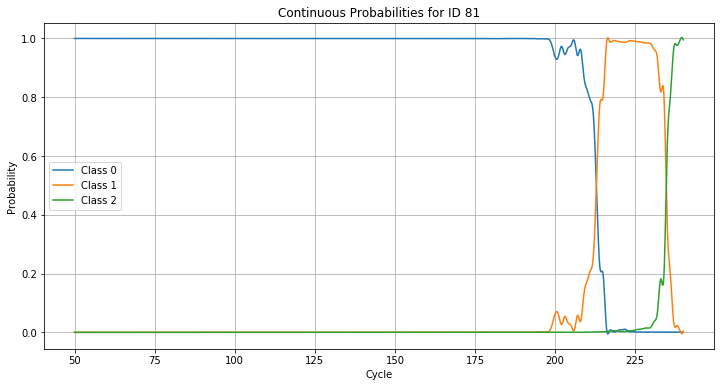

In [56]:
import pandas as pd
import numpy as np
import torch
from scipy.stats import lognorm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


from scipy.optimize import minimize_scalar
from scipy.integrate import quad
from scipy import optimize

def fit_lognormal_cdf(probabilities):
    # probabilities shape is (50, 3)
    # We'll use the cumulative probability of failure over time
    
    time_steps = np.arange(1, probabilities.shape[0] + 1)
    cumulative_failure_prob = np.cumsum(probabilities[:, 2])  # Assuming class 2 is "failure imminent"
    
    # Ensure probabilities are within (0, 1)
    cumulative_failure_prob = np.clip(cumulative_failure_prob, 1e-6, 1-1e-6)
    
    # Define the lognormal CDF
    def lognorm_cdf(x, s, loc, scale):
        return lognorm.cdf(x, s, loc, scale)
    
    # Define the error function to minimize
    def error(params, x, y):
        return np.sum((lognorm_cdf(x, *params) - y) ** 2)
    
    # Initial guess for parameters
    initial_guess = [1, 0, np.mean(time_steps)]
    
    # Fit the distribution
    result = optimize.minimize(error, initial_guess, args=(time_steps, cumulative_failure_prob))
    
    # Extract fitted parameters
    s, loc, scale = result.x
    
    # Convert lognorm parameters to mu and sigma
    sigma = s
    #mu = np.log(scale)
    mu = np.log(scale) if scale > 0 else np.nan    
    return mu, sigma


def plot_probabilities(pdm_df, estimator, scaler, params, cols_normalize_train, sequence_cols, device, id_range):
    for id in id_range:
        if id not in pdm_df['id'].unique():
            print(f"ID {id} not found in the dataset. Skipping.")
            continue

        probabilities_list = []
        cycles = []

        for current_cycle in range(params['seq_length'], pdm_df[pdm_df['id'] == id].shape[0] + 1):
            seq_array_test_k = prepare_sequence_data(pdm_df, scaler, id, current_cycle, params, cols_normalize_train, sequence_cols)
            seq_tensor = torch.tensor(seq_array_test_k, dtype=torch.float32).to(device)

            with torch.no_grad():
                outputs = estimator(seq_tensor)
                probabilities = torch.softmax(outputs.squeeze(), dim=1).cpu().numpy()

            probabilities_list.append(probabilities)
            cycles.append(current_cycle)

        probabilities_array = np.array(probabilities_list)
        cycles = np.array(cycles)
        # Plot continuous probabilities
        plt.figure(figsize=(12, 6))
        continuous_cycles = np.linspace(cycles.min(), cycles.max(), 1000)
        for i in range(3):  # Assuming 3 classes
            interp_func = interp1d(cycles, probabilities_array[:, -1, i], kind='cubic')
            continuous_probs = interp_func(continuous_cycles)
            plt.plot(continuous_cycles, continuous_probs, '-', label=f'Class {i}')
        plt.xlabel('Cycle')
        plt.ylabel('Probability')
        plt.title(f'Continuous Probabilities for ID {id}')
        plt.legend()
        plt.grid(True)
        plt.show()

        
# Usage
id_range = range(81, 82)  # This will plot for IDs 1, 2, 3, 4, and 5
plot_probabilities(pdm_df, estimator, scaler, params, cols_normalize_train, sequence_cols, device, id_range)

In [57]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import torch
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

def calculate_probabilities_for_pdm_policy_1_Without_ordering(estimator, pdm_df, scaler, params, cols_normalize_train, sequence_cols, C_p, C_c, L, DT, C_unav, C_inv):
    counter = 0
    t_LC_array = np.zeros(len(pdm_df['id'].unique()))
    costs_rep_array = np.zeros(len(pdm_df['id'].unique()))
    costs_delay_array = np.zeros(len(pdm_df['id'].unique()))
    costs_stock_array = np.zeros(len(pdm_df['id'].unique()))
    
    # Initialize dictionaries to store probabilities
    prob_RUL_smaller_DT_dict = {}  # All probabilities
    replacement_probs_dict = {}    # Probabilities at replacement
    
    # Move model to CPU
    estimator = estimator.cpu()
    estimator.eval()  # Set the model to evaluation mode
    
    for id in pdm_df['id'].unique():
        preventive_replacement = False
        prob_RUL_smaller_DT_dict[id] = []
        replacement_probs_dict[id] = []  # Store probabilities where replacement happens
        
        # Loop through each decision point
        for current_cycle in range(params['seq_length'], pdm_df[pdm_df['id'] == id].shape[0] + 1):
            if current_cycle in array_decisions:
                # Prepare data                           
                seq_array_test_k = prepare_sequence_data(pdm_df, scaler, id, current_cycle, params, cols_normalize_train, sequence_cols)
                                
                # Convert to tensor (on CPU)
                seq_tensor = torch.tensor(seq_array_test_k, dtype=torch.float32)
                
                # Predict
                with torch.no_grad():
                    outputs = estimator(seq_tensor).squeeze()
                probabilities = torch.softmax(outputs, dim=1).numpy()
                
                # Calculate probabilities
                prob_RUL_smaller_DT = probabilities[-1, 2]
                
                # Store probability for plotting
                prob_RUL_smaller_DT_dict[id].append((current_cycle, prob_RUL_smaller_DT))
                
                # Apply PdM policy 1
                pthres = 0.5  # Heuristic threshold

                if prob_RUL_smaller_DT < pthres:
                    action = "DN"  # Do Nothing
                    #print(f"DN decided for ID {id} at cycle {current_cycle}")
                else:
                    action = "PR"  # Preventive Replacement
                    #print(f"PR decided for ID {id} at cycle {current_cycle}")

                if action == "PR":
                    T_R_i = current_cycle
                    T_F_i = pdm_df[pdm_df['id'] == id]['cycle'].iloc[-1]
                    t_LC_array[counter] = min(T_R_i, T_F_i)  # Length of life cycle of ith component
                    costs_rep_array[counter] = C_p if T_R_i < T_F_i else C_c
                    preventive_replacement = True
                    costs_delay_array[counter] = max(0, L - t_LC_array[counter]) * C_unav
                    costs_stock_array[counter] = max(0, t_LC_array[counter] - L) * C_inv
                    
                    # Store probability where replacement is made
                    replacement_probs_dict[id].append((current_cycle, prob_RUL_smaller_DT))
                    break

        if not preventive_replacement:
            t_LC_array[counter] = pdm_df[pdm_df['id'] == id]['cycle'].iloc[-1]
            costs_rep_array[counter] = C_c
            
        counter += 1

    return t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array, prob_RUL_smaller_DT_dict, replacement_probs_dict

# Usage
t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array, prob_RUL_smaller_DT_dict, replacement_probs_dict = calculate_probabilities_for_pdm_policy_1_Without_ordering(estimator, pdm_df, scaler, params, cols_normalize_train, sequence_cols, C_p, C_c, L, DT, C_unav, C_inv)



## Call the Function and Plot both overall and replacement Probabilities to track the Replacement of components.

After running the function, you can plot the stored probabilities for each component:



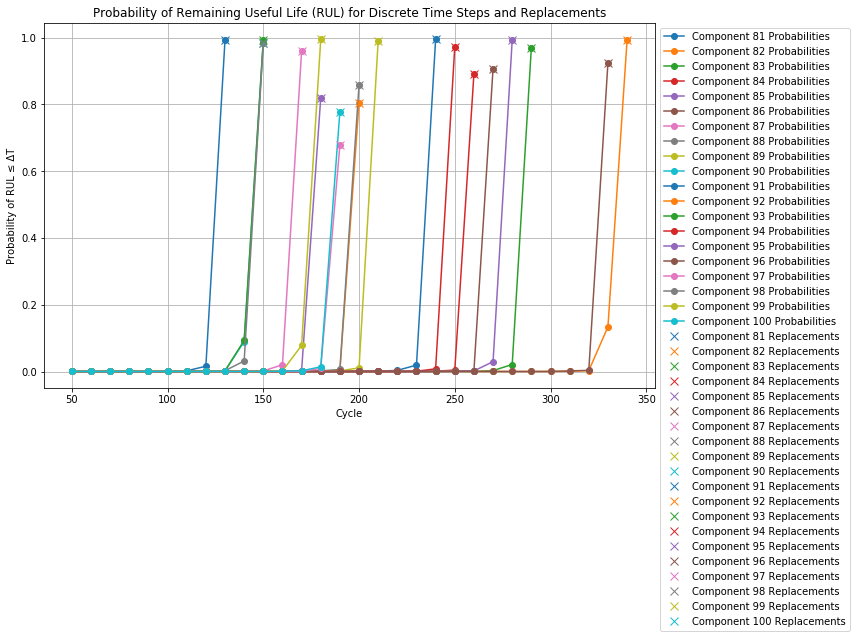

In [58]:
# Plot the probabilities for each component
plt.figure(figsize=(12, 8))

for id, probs in prob_RUL_smaller_DT_dict.items():
    if probs:  # Check if there are any probabilities to plot
        cycles, prob_values = zip(*probs)
        plt.plot(cycles, prob_values, linestyle='-', marker='o', label=f'Component {id} Probabilities')

# Plot the replacement probabilities for each component
for id, probs in replacement_probs_dict.items():
    if probs:  # Check if there are any replacement probabilities to plot
        cycles, prob_values = zip(*probs)
        plt.plot(cycles, prob_values, linestyle='', marker='x', markersize=8, label=f'Component {id} Replacements')

plt.xlabel('Cycle')
plt.ylabel('Probability of RUL ≤ ΔT')
plt.title('Probability of Remaining Useful Life (RUL) for Discrete Time Steps and Replacements')

# Position the legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()


In [59]:
t_LC_array

array([240., 200., 290., 260., 180., 270., 170., 200., 210., 150., 130.,
       340., 150., 250., 280., 330., 190., 150., 180., 190.])

In [60]:
costs_rep_array

array([1000.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.])

In [61]:
costs_delay_array

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [62]:
costs_stock_array

array([220., 180., 270., 240., 160., 250., 150., 180., 190., 130., 110.,
       320., 130., 230., 260., 310., 170., 130., 160., 170.])

## Implementing PDM Policy 1 with Ordering

In [63]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import torch

def calculate_probabilities_for_pdm_policy_1_With_ordering(estimator, pdm_df, scaler, params, cols_normalize_train, sequence_cols, C_p, C_c, L, DT, C_unav, C_inv):
    counter = 0
    t_order_array = np.zeros(len(pdm_df['id'].unique()))
    t_LC_array = np.zeros(len(pdm_df['id'].unique()))
    costs_rep_array = np.zeros(len(pdm_df['id'].unique()))
    costs_delay_array = np.zeros(len(pdm_df['id'].unique()))
    costs_stock_array = np.zeros(len(pdm_df['id'].unique()))
    w = np.ceil(L / DT) * DT
    
    # Move model to CPU and set to evaluation mode
    estimator = estimator.cpu()
    estimator.eval()
    
    for id in pdm_df['id'].unique():
        preventive_replacement = False
        order = False

        for current_cycle in range(params['seq_length'], pdm_df[pdm_df['id'] == id].shape[0] + 1):
            if current_cycle in array_decisions:
                # Prepare data
                seq_array_test_k = prepare_sequence_data(pdm_df, scaler, id, current_cycle, params, cols_normalize_train, sequence_cols)

                # Convert to tensor (on CPU)
                seq_tensor = torch.tensor(seq_array_test_k, dtype=torch.float32)

                # Predict
                with torch.no_grad():
                    outputs = estimator(seq_tensor).squeeze()
                probabilities = torch.softmax(outputs, dim=1).numpy()

                # Calculate probabilities
                prob_RUL_smaller_w1 = (probabilities[-1, 1] + probabilities[-1, 2])
                prob_RUL_smaller_DT = probabilities[-1, 2]

                # Apply optimized heuristic thresholds
                p_order_thres = 0.11  # Optimized heuristic threshold for ordering
                p_rep_thres = 0.5     # Optimized heuristic threshold for replacement

                # Ordering decision
                if not order and prob_RUL_smaller_w1 >= p_order_thres:
                    #t_order_array[counter] = current_cycle + w
                    t_order_array[counter] = current_cycle
                    order = True

                # Replacement decision
                if prob_RUL_smaller_DT < p_rep_thres:
                    action = "DN"  # Do Nothing
                    #print(f"DN decided for ID {id} at cycle {current_cycle}")
                else:
                    action = "PR"  # Preventive Replacement
                    #print(f"PR decided for ID {id} at cycle {current_cycle}")

                if action == "PR":
                    T_R_i = current_cycle
                    T_F_i = pdm_df[pdm_df['id'] == id]['cycle'].iloc[-1]
                    t_LC_array[counter] = min(T_R_i, T_F_i)
                    costs_rep_array[counter] = C_p if T_R_i < T_F_i else C_c
                    preventive_replacement = True
                    #costs_delay_array[counter] = max(0, L - t_LC_array[counter]) * C_unav
                    #costs_stock_array[counter] = max(0, t_LC_array[counter] - L) * C_inv
                    costs_delay_array[counter] = max(t_order_array[counter]+L-t_LC_array[counter], 0) * C_unav
                    costs_stock_array[counter]  = max(t_LC_array[counter] -(t_order_array[counter]+L), 0)*C_inv
                    break

        if not preventive_replacement:
            t_LC_array[counter] = pdm_df[pdm_df['id'] == id]['cycle'].iloc[-1]
            costs_rep_array[counter] = C_c

            if not order:
                costs_delay_array[counter] = L * C_unav
                costs_stock_array[counter] = 0  # No stock cost if no order was placed
            else:
                costs_delay_array[counter] = max(t_order_array[counter] + L - t_LC_array[counter], 0) * C_unav
                costs_stock_array[counter] = max(t_LC_array[counter] - (t_order_array[counter] + L), 0) * C_inv

        counter += 1

    return t_order_array, t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array

# Usage
t_order_array, t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array = calculate_probabilities_for_pdm_policy_1_With_ordering(estimator, pdm_df, scaler, params, cols_normalize_train, sequence_cols, C_p, C_c, L, DT, C_unav, C_inv)



In [64]:
costs_rep_array

array([1000.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.])

In [65]:
costs_delay_array

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.])

In [66]:
costs_stock_array

array([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,
        0.,  0.,  0.,  0.,  0.,  0., 10.])

In [67]:
costs_tot = costs_rep_array+costs_delay_array+costs_stock_array
costs_tot

array([1010.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.,  100.,  110.,  100.,  100.,  100.,  200.,  100.,
        100.,  110.])

In [68]:
t_LC_array

array([240., 200., 290., 260., 180., 270., 170., 200., 210., 150., 130.,
       340., 150., 250., 280., 330., 190., 150., 180., 190.])

In [69]:
t_order_array

array([210., 180., 270., 240., 160., 250., 150., 180., 190., 130., 110.,
       320., 120., 230., 260., 310., 180., 130., 160., 160.])

## Implementing PDM policy 2

1. `Objective:` PDM policy 2 aims to find the optimal time for preventive replacement (T_{R,k}*) by minimizing the long-run expected maintenance cost per unit time. <br>
2. `Decision Rule:` At each time step t_k, the policy decides:
> * Perform Preventive Replacement (PR) if t_k + ΔT ≥ T_{R,k}*
> * Do Nothing (DN) otherwise
3. `Optimization Problem:` The policy solves an optimization problem at each time step to find T_{R,k}* by minimizing the objective function f(T_{R,k}) given in Equation 12. <br>
4. `Components of the Objective Function (Equation 12):`
> $f\left(T_{\mathrm{R}, k}\right)=\frac{\mathrm{E}\left[C_{\mathrm{rep}}\left(T_{\mathrm{R}, k}\right)\right]}{\mathrm{E}\left[T_{\mathrm{lc}}\left(T_{\mathrm{R}, k}\right)\right]}=\frac{P_{\mathrm{PR}} \cdot c_{\mathrm{p}}+\left(1-P_{\mathrm{PR}}\right) \cdot c_{\mathrm{c}}}{P_{\mathrm{PR}} \cdot\left(T_{\mathrm{R}, k}\right)+\int_t^{T_{\mathrm{R}, k}} t f_{R U L_{\mathrm{Pred}, k}}\left(t-t_k\right) \mathrm{d} t}$
> * E[C_{rep}(T_{R,k})]: Expected cost of replacement
> * E[T_{lc}(T_{R,k})]: Expected lifecycle time
> * P_{PR}: Probability of preventive replacement (defined in Equation 13)
> * c_p: Cost of preventive replacement
> * c_c: Cost of corrective replacement (failure)
> * f_{RUL_{pred,k}}(t): Full distribution of the RUL prediction at time t_k
> * The find_optimal_replacement_time function implements the objective function from PDM policy 2. It finds the optimal replacement time T_R_k by minimizing the expected cost per unit time. <br>

5. Interpretation of Equation 12:
> * Numerator: Represents the expected cost, considering both preventive and corrective replacements.
> * Denominator: Represents the expected lifecycle time.
> * By minimizing this ratio, the policy aims to find the optimal balance between cost and component lifetime.


6. Probability of Preventive Replacement(Equation 13): 
> P_{PR} represents the probability that the component will be preventively replaced at T_{R,k}.
> It's calculated by integrating the RUL prediction distribution from T_{R,k} to infinity.

> $$
P_{\mathrm{PR}}=\int_{T_{\mathrm{R}, k}}^{\infty} f_{R U L_{\mathrm{Pred}, k}}\left(t-t_k\right) \mathrm{d} t
$$       

7. Full RUL Distribution: Unlike PDM policy 1, this policy uses the full distribution of the Remaining Useful Life (RUL) prediction, allowing for more nuanced decision-making.<br>

8. The function `find_optimal_replacement_time` and its Parameters: function is designed to determine the optimal time for preventive replacement in a Predictive Maintenance (PdM) system. It uses a lognormal distribution fitted to the predicted probabilities of component failure to calculate the expected cost per unit time and find the optimal replacement time.<br>
 , representing the probability of needing a preventive replacement after T_R_K. <br>
> `probabilities:` The predicted probabilities of class1 and class2 from the model. <br>
> C_p, C_c, current_cycle, seq_length <br>
> `Fitting the Lognormal Distribution:` `mu, sigma = fit_lognormal_cdf(probabilities):` This fits a lognormal distribution to the given probabilities, returning the parameters mu and sigma..
> * `Probability of Preventive Replacement (P_PR):` This is the probability that the component survives until T_R_k. <br>
> * `Expected Replacement Cost (E_C_rep) :` It's a weighted sum of preventive (C_p) and corrective (C_c) replacement costs.<br> 
> * `Expected Lifecycle Time (E_T_lc) :` The first term (P_PR * T_R_k) is the expected time if preventive replacement occurs
and The sum calculates the expected time if failure occurs before T_R_k.<br>

9. `Optimization:`
> * Uses scipy's `minimize_scalar` function to find the T_R_k that minimizes the objective function.<br>
> * The search is bounded between the current cycle and the end of the sequence.<br>


## Without ordering

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.integrate import quad
from scipy.stats import lognorm
import torch

import warnings
from scipy.integrate import quad, IntegrationWarning

def calculate_probabilities_for_pdm_policy_2_Without_ordering(estimator, pdm_df, scaler, params, cols_normalize_train, sequence_cols, C_p, C_c, L, DT, C_unav, C_inv):
    counter = 0
    t_LC_array = np.zeros(len(pdm_df['id'].unique()))
    costs_rep_array = np.zeros(len(pdm_df['id'].unique()))
    costs_delay_array = np.zeros(len(pdm_df['id'].unique()))
    costs_stock_array = np.zeros(len(pdm_df['id'].unique()))
    optimal_replacement_times = {}
    rul_distributions = {}

    # Move model to CPU and set to evaluation mode
    estimator = estimator.cpu()
    estimator.eval()

    for id in pdm_df['id'].unique():
        preventive_replacement = False
        optimal_replacement_times[id] = []
        rul_distributions[id] = []

        for current_cycle in range(params['seq_length'], pdm_df[pdm_df['id'] == id].shape[0] + 1):
            if current_cycle in array_decisions:
                # Prepare data
                seq_array_test_k = prepare_sequence_data(pdm_df, scaler, id, current_cycle, params, cols_normalize_train, sequence_cols)
                
                # Convert to tensor (on CPU)
                seq_tensor = torch.tensor(seq_array_test_k, dtype=torch.float32)

                # Predict
                with torch.no_grad():
                    outputs = estimator(seq_tensor).squeeze()
                probabilities = torch.softmax(outputs, dim=1).numpy()

                # Calculate optimal replacement time
                T_R_k_optimal = find_optimal_replacement_time_for_PDM_Policy2(probabilities, C_p, C_c, current_cycle, DT, params)
                optimal_replacement_times[id].append((current_cycle, T_R_k_optimal))
                
                # Store RUL distribution
                mu, sigma = fit_lognormal_cdf(probabilities)
                rul_distributions[id].append((current_cycle, mu, sigma))

                if DT >= T_R_k_optimal:     
                    action = "PR"  # Preventive Replacement
                    #print(f"PR decided for ID {id} at cycle {current_cycle}. T_R_k_optimal: {T_R_k_optimal}, DT: {DT}")
                else:
                    action = "DN"  # Do Nothing
                    #print(f"DN decided for ID {id} at cycle {current_cycle}. T_R_k_optimal: {T_R_k_optimal}, DT: {DT}")
                # Preventive replacement decision
                if action == "PR":
                    T_R_i = current_cycle
                    T_F_i = pdm_df[pdm_df['id'] == id]['cycle'].iloc[-1]
                    t_LC_array[counter] = min(T_R_i, T_F_i)
                    costs_rep_array[counter] = C_p if T_R_i < T_F_i else C_c
                    preventive_replacement = True
                    costs_delay_array[counter] = max(0, L - t_LC_array[counter]) * C_unav
                    costs_stock_array[counter] = max(0, t_LC_array[counter] - L) * C_inv
                    break

        if not preventive_replacement:
            t_LC_array[counter] = pdm_df[pdm_df['id'] == id]['cycle'].iloc[-1]
            costs_rep_array[counter] = C_c

        counter += 1

    return t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array, optimal_replacement_times, rul_distributions

# The rest of the functions remain unchanged

def find_optimal_replacement_time_for_PDM_Policy2(probabilities, C_p, C_c, current_cycle, DT, params):
    """Find the optimal replacement time for PdM policy 2."""
    mu, sigma = fit_lognormal_cdf(probabilities)

    def objective_function(T_R_k):
        P_PR = 1 - lognorm.cdf(T_R_k - current_cycle, s=sigma, scale=np.exp(mu))
        E_C_rep = P_PR * C_p + (1 - P_PR) * C_c
        E_T_lc = P_PR * T_R_k + expected_time_to_failure(current_cycle, T_R_k, mu, sigma)
        return E_C_rep / max(E_T_lc, 1e-6)  # Avoid division by zero

    try:
        result = minimize_scalar(objective_function, bounds=(0,  2 * DT), method='bounded')
        return result.x
    except Exception as e:
        print(f"Optimization error: {str(e)}")
        return current_cycle + DT  # Return a default value



def expected_time_to_failure(current_cycle, T_R_k, mu, sigma):
    
    def integrand(t):
        return t * lognorm.pdf(t - current_cycle, s=sigma, scale=np.exp(mu))

    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", IntegrationWarning)
            integral_value, error = quad(integrand, current_cycle, T_R_k, 
                                         limit=200, epsabs=1e-6, epsrel=1e-6,
                                         points=[current_cycle, T_R_k])
        return integral_value
    except Exception as e:
        print(f"Integration error: {str(e)}")
        # Return a default value or handle the error as appropriate
        return T_R_k - current_cycle  # Simple fallback: assume failure at T_R_k
    
"""

def expected_time_to_failure(current_cycle,T_R_k, mu, sigma):
    
    def integrand(t):
        return t * lognorm.pdf(t - current_cycle, mu, sigma)

    #integral_value, error = quad(integrand, current_cycle, T_R_k, limit=200)
    integral_value, error = quad(integrand, current_cycle, T_R_k, limit=200, epsabs=1e-6, epsrel=1e-6)

    return integral_value

"""


# Run the optimization function and compute the RUL distribution
t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array, optimal_replacement_times, rul_distributions = calculate_probabilities_for_pdm_policy_2_Without_ordering(
    estimator, pdm_df, scaler, params, cols_normalize_train, sequence_cols, C_p, C_c, L, DT, C_unav, C_inv)

In [71]:
t_LC_array

array([240., 200., 290., 260., 180., 270., 170., 190., 210., 140., 130.,
       330., 140., 250., 270., 330., 190., 130., 170., 190.])

In [72]:
costs_rep_array

array([1000.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.])

In [73]:
costs_delay_array

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [74]:
costs_stock_array

array([220., 180., 270., 240., 160., 250., 150., 170., 190., 120., 110.,
       310., 120., 230., 250., 310., 170., 110., 150., 170.])

## Plot the RUL Distribution for discrete time steps

 * Use the modified functions to calculate and plot the RUL distribution for each cycle: 

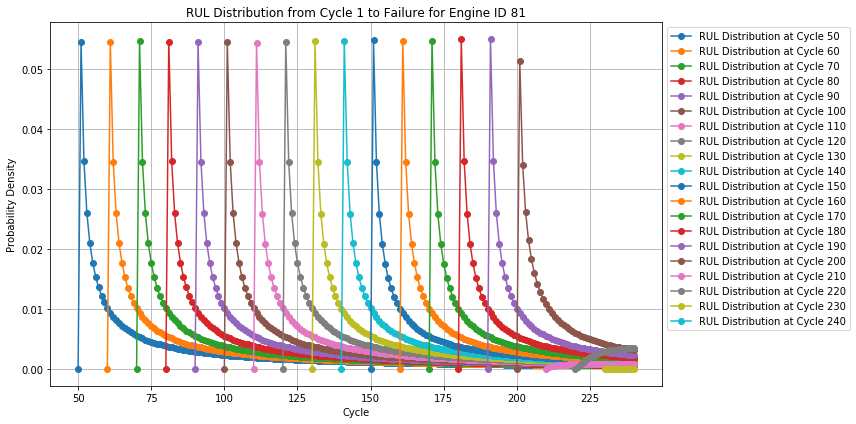

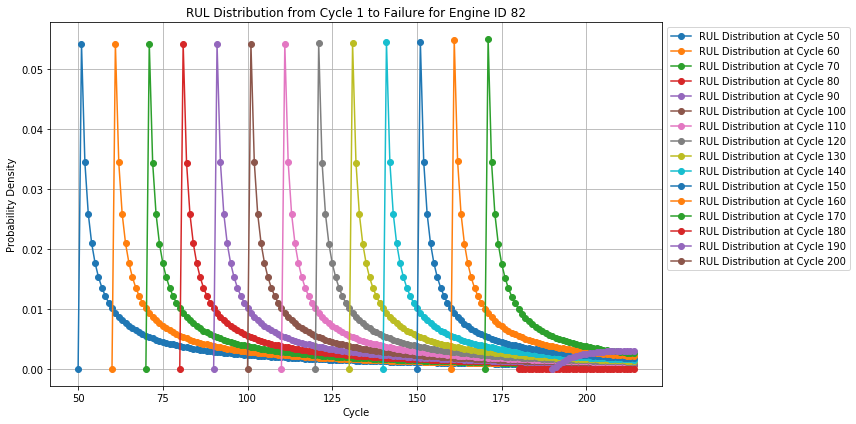

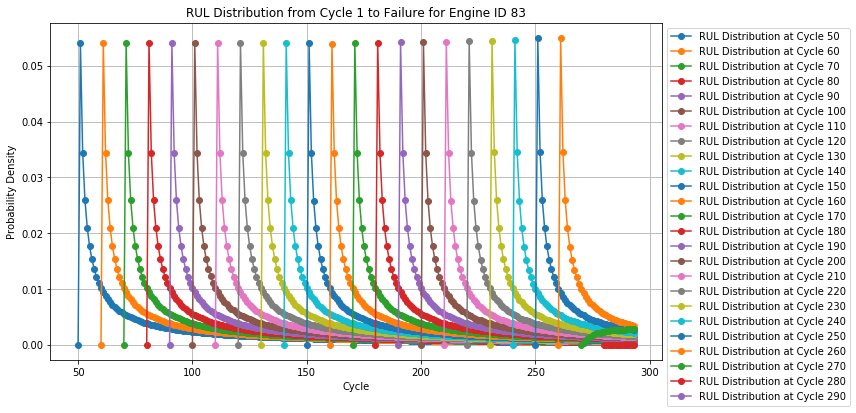

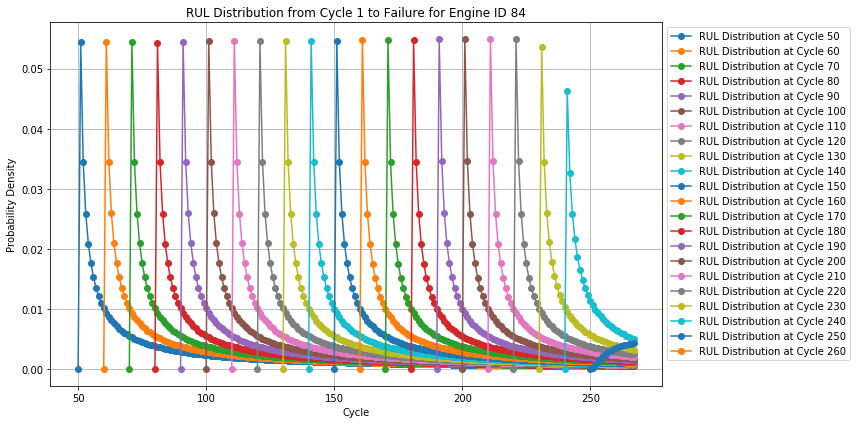

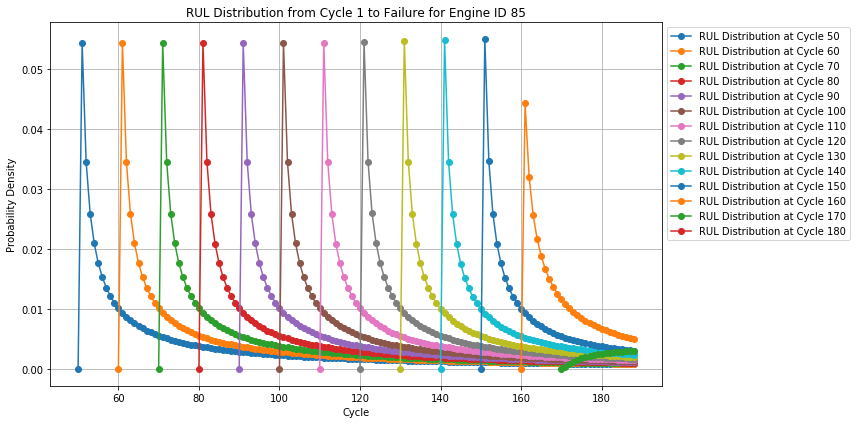

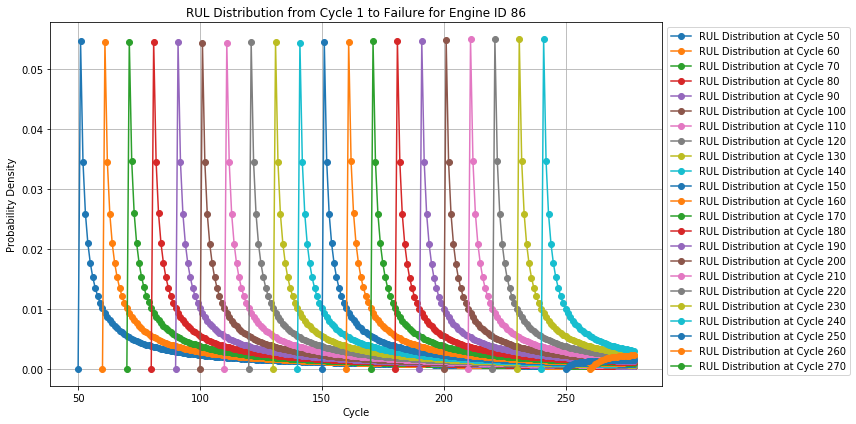

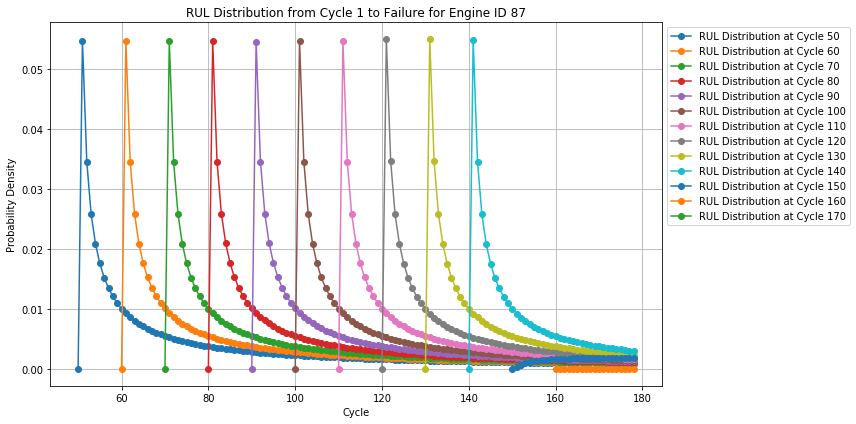

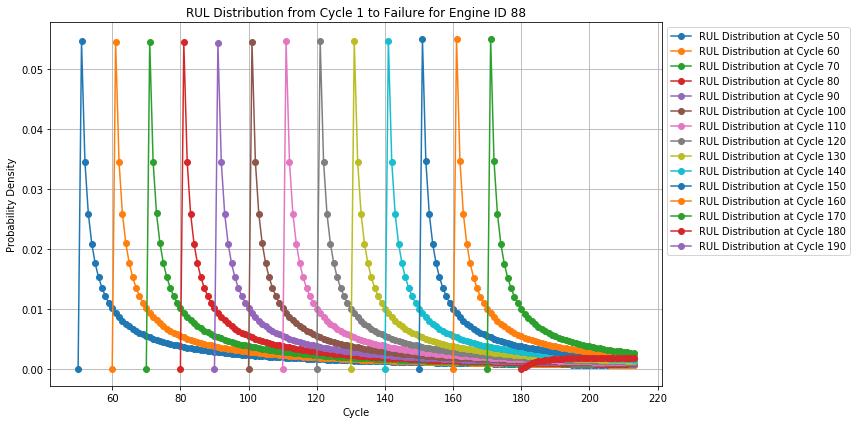

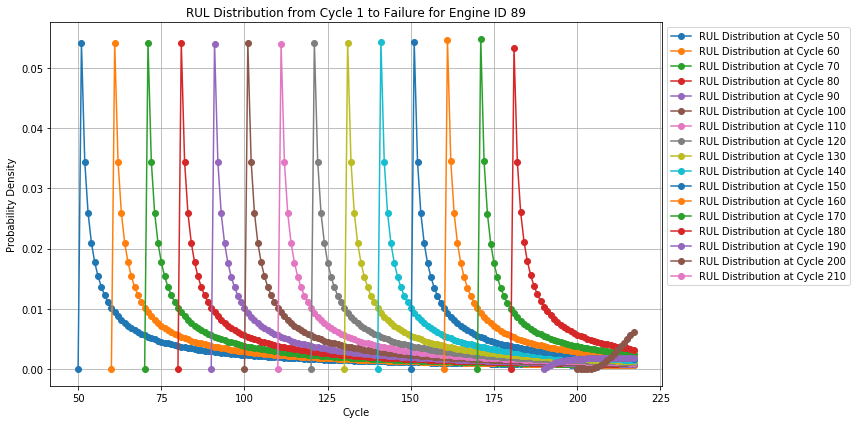

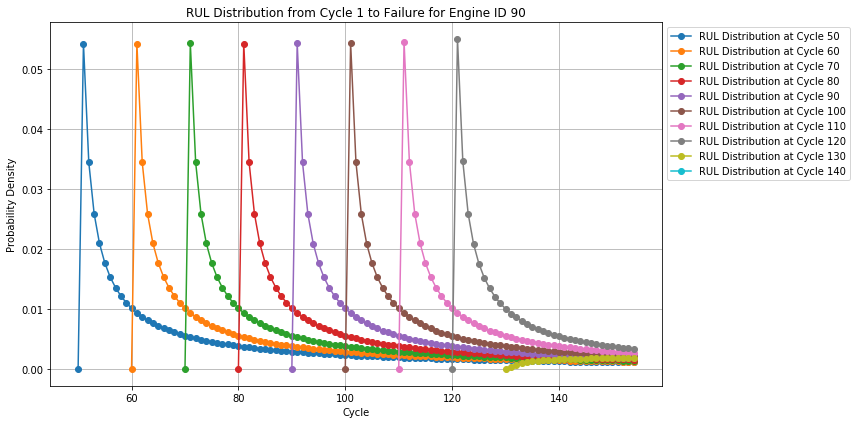

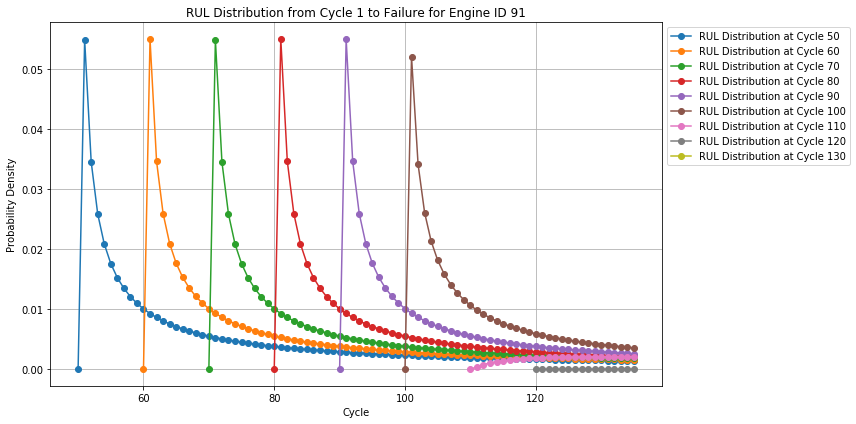

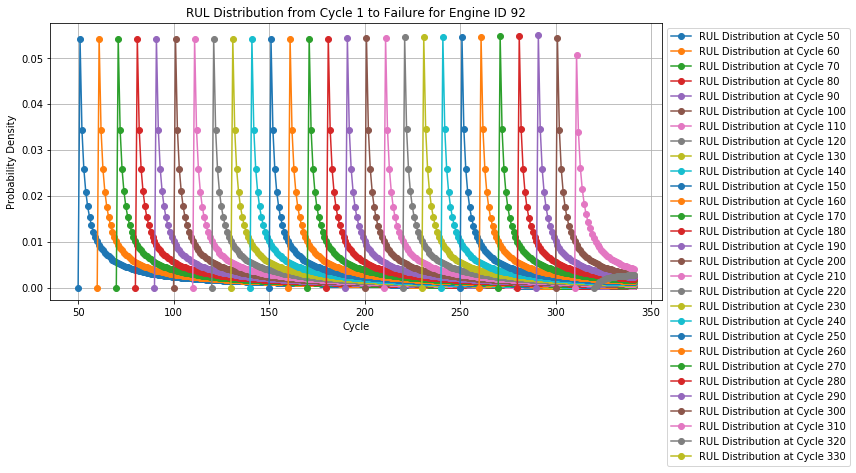

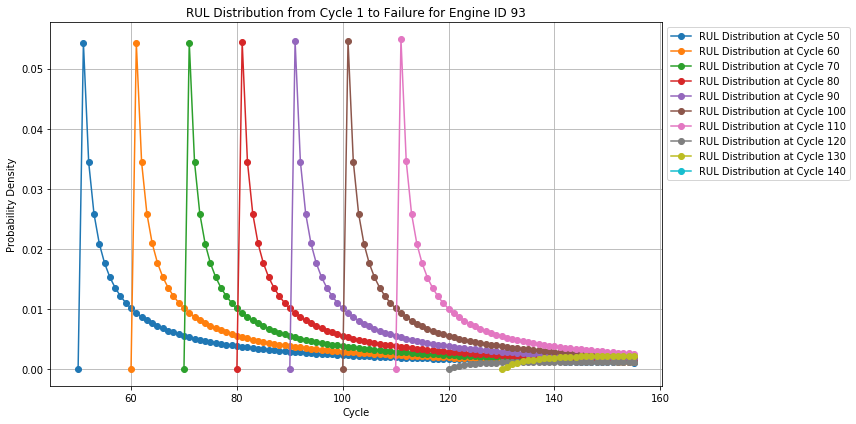

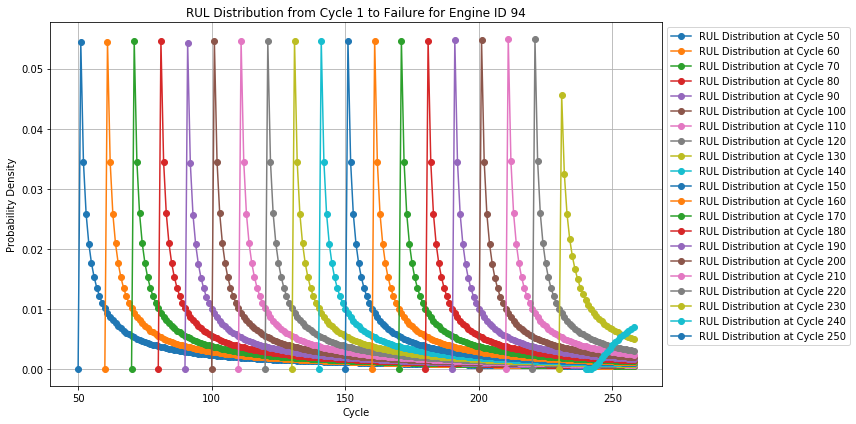

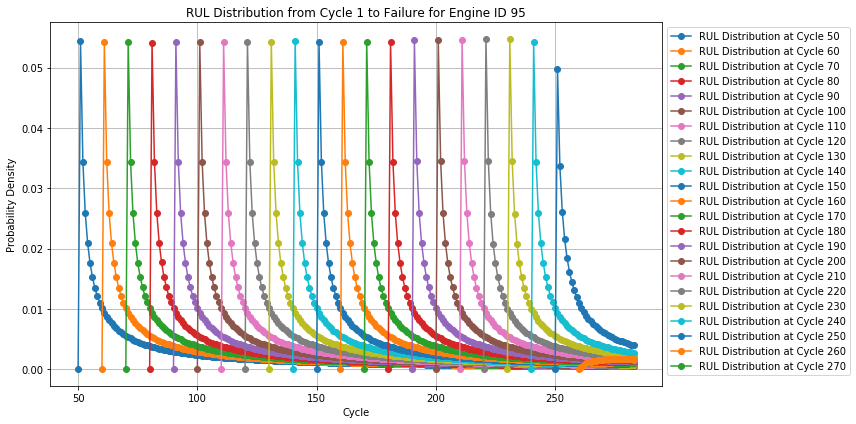

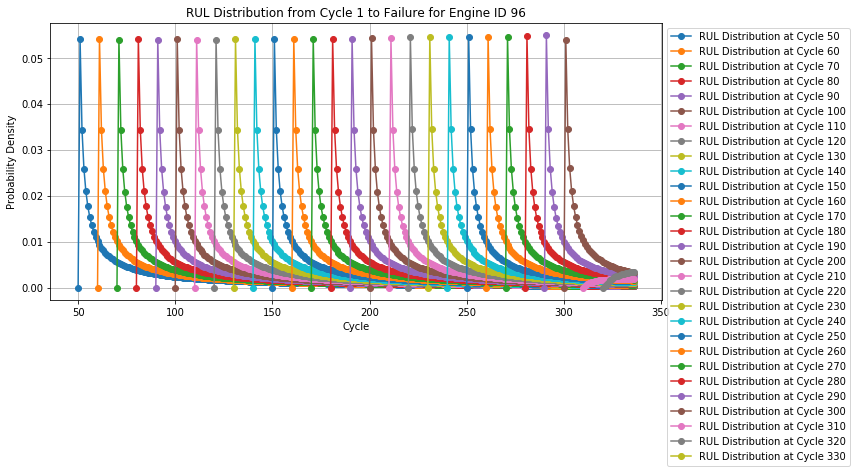

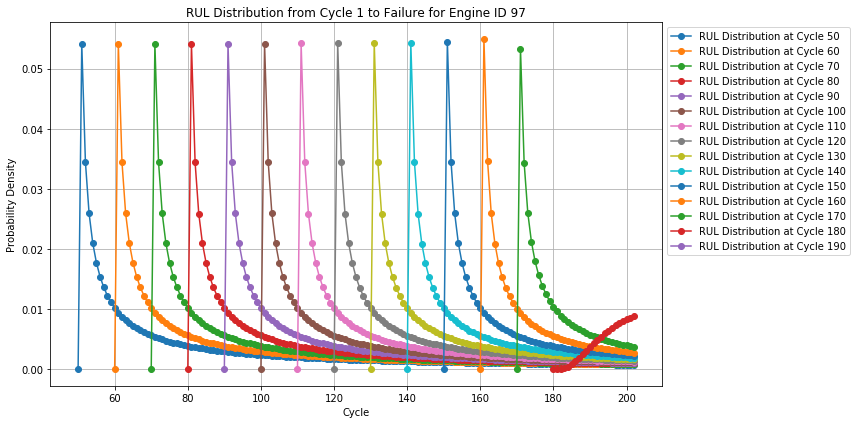

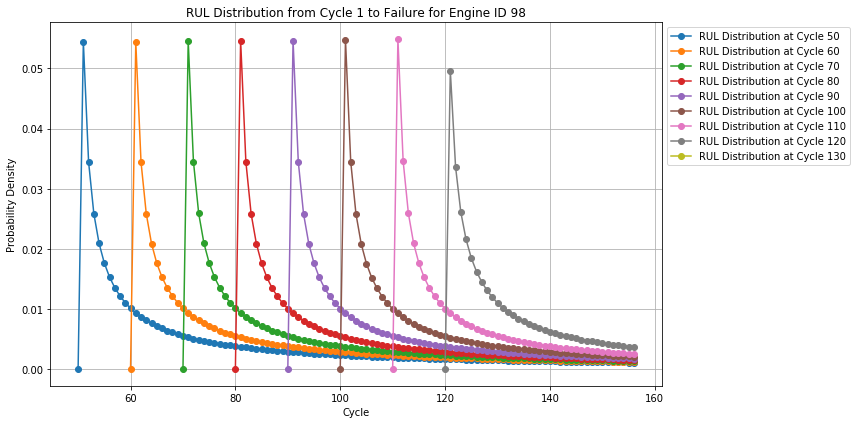

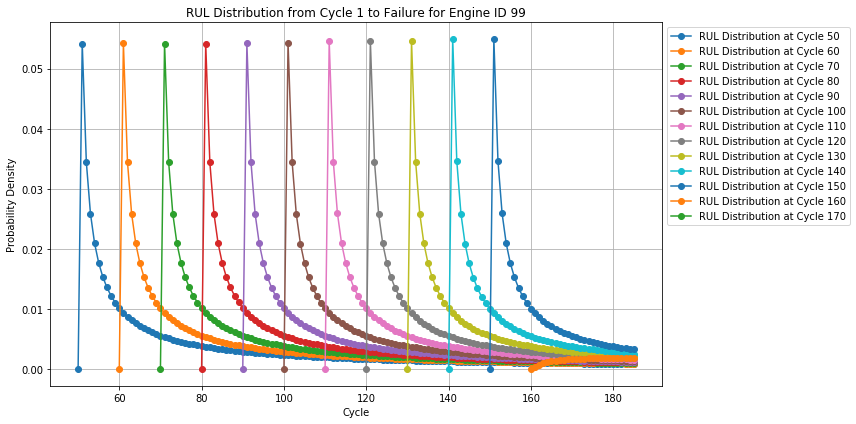

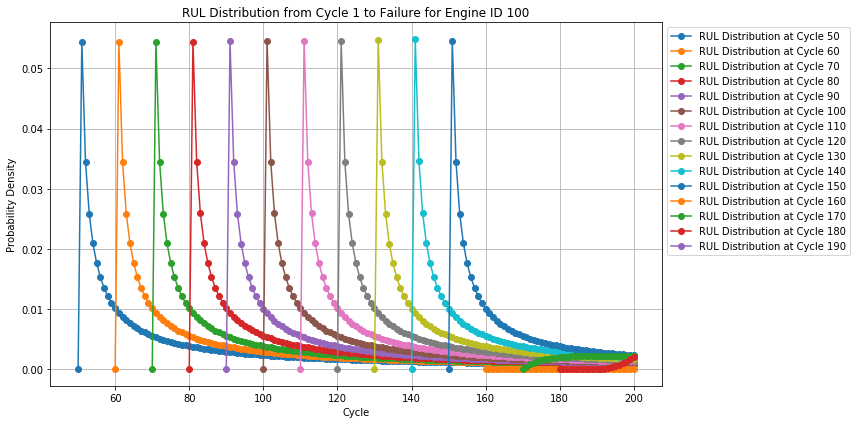

In [75]:
def plot_rul_distribution_for_each_id(rul_distributions, array_decisions):
    """
    Plot the RUL distribution per cycle for each engine ID from cycle 1 to its failure cycle.
    
    Args:
        rul_distributions (dict): Dictionary containing RUL distribution data for each engine ID.
        array_decisions (numpy.ndarray): Array of discrete decision points (time steps).
    """
    for id, rul_data in rul_distributions.items():
        plt.figure(figsize=(12, 6))
        
        # Plot for each cycle from 1 to the failure cycle
        for (current_cycle, mu, sigma) in rul_data:
            # Only plot if cycle is in the decision points
            if current_cycle in array_decisions:
                # Generate x values for RUL distribution from current cycle to the end
                discrete_times = np.arange(current_cycle, pdm_df[pdm_df['id'] == id]['cycle'].iloc[-1] + 1)

                # Calculate the lognormal PDF for the RUL distribution
                f_rul_pred_k = lognorm.pdf(discrete_times - current_cycle, s=sigma, scale=np.exp(mu))

                plt.plot(discrete_times, f_rul_pred_k, linestyle='-', marker='o', label=f'RUL Distribution at Cycle {current_cycle}')

        plt.xlabel('Cycle')
        plt.ylabel('Probability Density')
        plt.title(f'RUL Distribution from Cycle 1 to Failure for Engine ID {id}')
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        
# Calculate probabilities, RUL distributions, and optimal replacement times
t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array, optimal_replacement_times, rul_distributions = calculate_probabilities_for_pdm_policy_2_Without_ordering(
    estimator, pdm_df, scaler, params, cols_normalize_train, sequence_cols, C_p, C_c, L, DT, C_unav, C_inv)

# Plot the RUL distributions from cycle 1 to the failure cycle for each engine ID
plot_rul_distribution_for_each_id(rul_distributions, array_decisions)


## Plotting the Objective Function per Cycle
 * use the returned optimal_replacement_times to visualize the replacement times over cycles:

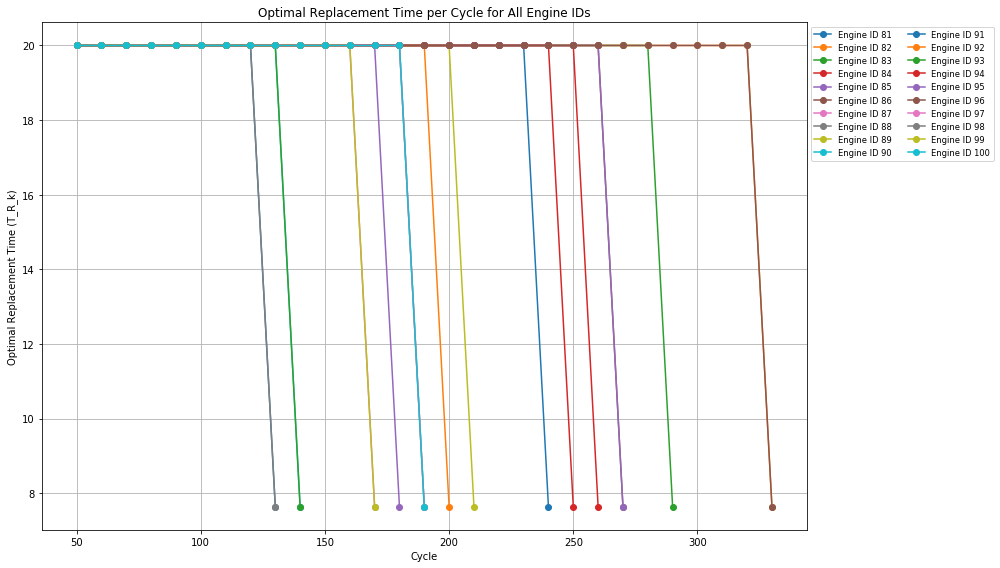

In [76]:
def plot_combined_optimal_replacement_time(optimal_replacement_times):
    """
    Plot the optimal replacement time (T_R_k_optimal) per cycle for all engine IDs in a single plot.
    
    Args:
        optimal_replacement_times (dict): Dictionary containing optimal replacement times for each engine ID.
    """
    plt.figure(figsize=(14, 8))

    # Iterate over each engine ID's optimal replacement times
    for id, replacement_data in optimal_replacement_times.items():
        # Extract cycles and optimal replacement times for the current engine ID
        cycles = [data[0] for data in replacement_data]
        optimal_times = [data[1] for data in replacement_data]

        # Plot the optimal replacement time for the current engine ID
        plt.plot(cycles, optimal_times, linestyle='-', marker='o', label=f'Engine ID {id}')

    plt.xlabel('Cycle')
    plt.ylabel('Optimal Replacement Time (T_R_k)')
    plt.title('Optimal Replacement Time per Cycle for All Engine IDs')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
        
        


# Plot the combined optimal replacement times for all engine IDs
plot_combined_optimal_replacement_time(optimal_replacement_times)


## with ordering

In [77]:
import numpy as np
import torch
from scipy.optimize import minimize_scalar
from scipy.stats import lognorm
from scipy.integrate import quad

def calculate_probabilities_for_pdm_policy_2_With_ordering(estimator, pdm_df, scaler, params, cols_normalize_train, sequence_cols, C_p, C_c, L, DT, C_unav, C_inv):
    counter = 0
    t_order_array = np.zeros(len(pdm_df['id'].unique()))
    t_LC_array = np.zeros(len(pdm_df['id'].unique()))
    costs_rep_array = np.zeros(len(pdm_df['id'].unique()))
    costs_delay_array = np.zeros(len(pdm_df['id'].unique()))
    costs_stock_array = np.zeros(len(pdm_df['id'].unique()))
    w = np.ceil(L / DT) * DT

    # Move model to CPU and set to evaluation mode
    estimator = estimator.cpu()
    estimator.eval()

    for id in pdm_df['id'].unique():
        preventive_replacement = False
        order = False

        for current_cycle in range(params['seq_length'], pdm_df[pdm_df['id'] == id].shape[0] + 1):
            if current_cycle in array_decisions:
                # Prepare data
                seq_array_test_k = prepare_sequence_data(pdm_df, scaler, id, current_cycle, params, cols_normalize_train, sequence_cols)
                # Convert to tensor (on CPU)
                seq_tensor = torch.tensor(seq_array_test_k, dtype=torch.float32)

                # Predict
                with torch.no_grad():
                    outputs = estimator(seq_tensor).squeeze()
                probabilities = torch.softmax(outputs, dim=1).numpy()

                # Calculate optimal replacement time
                T_R_k_optimal = find_optimal_replacement_time_for_PDM_Policy2(probabilities, C_p, C_c, current_cycle, DT, params)

                # Apply PDM policy 2
                if DT >= T_R_k_optimal:     
                    action = "PR"  # Preventive Replacement
                    #print(f"PR decided for ID {id} at cycle {current_cycle}. T_R_k_optimal: {T_R_k_optimal}, DT: {DT}")
                else:
                    action = "DN"  # Do Nothing
                    #print(f"DN decided for ID {id} at cycle {current_cycle}. T_R_k_optimal: {T_R_k_optimal}, DT: {DT}")

                # Ordering decision
                prob_RUL_smaller_w1 = probabilities[-1, 1] + probabilities[-1, 2]
                p_order_thres = 0.11  # Heuristic threshold for ordering
                if not order and prob_RUL_smaller_w1 >= p_order_thres:
                    #t_order_array[counter] = current_cycle + w
                    t_order_array[counter] = current_cycle 
                    order = True

                # Preventive replacement decision
                if action == "PR":
                    T_R_i = current_cycle
                    T_F_i = pdm_df[pdm_df['id'] == id]['cycle'].iloc[-1]
                    t_LC_array[counter] = min(T_R_i, T_F_i)
                    costs_rep_array[counter] = C_p if T_R_i < T_F_i else C_c
                    preventive_replacement = True
                    costs_delay_array[counter] = max(t_order_array[counter] + L - t_LC_array[counter], 0) * C_unav
                    costs_stock_array[counter] = max(t_LC_array[counter] - (t_order_array[counter] + L), 0) * C_inv
                    break

        if not preventive_replacement:
            t_LC_array[counter] = pdm_df[pdm_df['id'] == id]['cycle'].iloc[-1]
            costs_rep_array[counter] = C_c

            if not order:
                costs_delay_array[counter] = L * C_unav
                costs_stock_array[counter] = 0  # No stock cost if no order was placed
            else:
                costs_delay_array[counter] = max(t_order_array[counter] + L - t_LC_array[counter], 0) * C_unav
                costs_stock_array[counter] = max(t_LC_array[counter] - (t_order_array[counter] + L), 0) * C_inv

        counter += 1

    return t_order_array, t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array




# Usage
# Calculate probabilities, RUL distributions, and optimal replacement times
t_order_array, t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array = calculate_probabilities_for_pdm_policy_2_With_ordering(estimator, pdm_df,scaler, params, cols_normalize_train, sequence_cols, C_p, C_c, L,DT, C_unav, C_inv)


In [78]:
t_order_array

array([210., 180., 270., 240., 160., 250., 150., 180., 190., 130., 110.,
       320., 120., 230., 260., 310., 180., 130., 160., 160.])

In [79]:
t_LC_array

array([240., 200., 290., 260., 180., 270., 170., 190., 210., 140., 130.,
       330., 140., 250., 270., 330., 190., 130., 170., 190.])

In [80]:
costs_rep_array

array([1000.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.])

In [81]:
costs_delay_array

array([  0.,   0.,   0.,   0.,   0.,   0.,   0., 100.,   0., 100.,   0.,
       100.,   0.,   0., 100.,   0., 100., 200., 100.,   0.])

In [82]:
costs_stock_array

array([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., 10.])

## PDM Policy 3 

1. `Objective: `PDM Policy 3 represents a significant advancement in predictive maintenance by utilizing the full distribution of RUL data to inform maintenance decisions. The objective function captures both the expected costs of preventive and corrective actions and the additional costs associated with early replacements, providing a comprehensive framework for optimizing maintenance strategies. <br>
2. `Explanation of Equation(14): ` The equation for the objective function in PDM Policy 3 is given as:
> $f\left(T_{\mathrm{R}, k}\right)=P_{\mathrm{PR}} \cdot C_{\mathrm{p}}+\left(1-P_{\mathrm{PR}}\right) \cdot C_{\mathrm{c}}+\int_{T_{\mathrm{R}, k}}^{\infty}\left(t-T_{\mathrm{R}, k}\right) \cdot \frac{\mathrm{E}_{\bar{T}_{\mathrm{F}}}\left[C_{\mathrm{rep}}\right]}{\mathrm{E}_{\bar{T}_{\mathrm{F}}}\left[T_{l \mathrm{c}}\right]} f_{R U L_{\mathrm{pred}, k}}\left(t-t_k\right) \mathrm{d} t$

3. `Components of the equation: `

>  1. `Expected Replacement Cost: `
>> * The first two terms, $P_{\mathrm{PR}} \cdot C_{\mathrm{p}}$ and $\left(1-P_{\mathrm{PR}}\right) \cdot C_{\mathrm{c}}$ represent the expected costs associated with preventive and corrective replacements, respectively. <br>
>> * $P_{\mathrm{PR}}$ is the probability that the components will survive until the replacement time $T_{\mathrm{R}, k}$ <br>
>> * $ C_{\mathrm{p}}$ is the cost of preventive replacement, and $ C_{\mathrm{c}}$ is the cost of corrective replacement. <br>

> 2. `Integral Term: `
>> * The integral term quantifies the additional expected maintenance cost associated with an "early" replacement at $T_{\mathrm{R}, k}$ <br>
>> * The expression $ \left(t-T_{\mathrm{R}, k}\right) $ represents the time lost due to an early replacement.
>> * The term $ \frac{\mathrm{E}_{\bar{T}_{\mathrm{F}}}\left[C_{\mathrm{rep}}\right]}{\mathrm{E}_{\bar{T}_{\mathrm{F}}}\left[T_{l \mathrm{c}}\right]} $  is the long-run expected maintenance cost per unit time concerning the distribution of the population of components. It provides a scaling factor for the additional cost incurred by replacing the component early. <br> 
>> * $ f_{R U L_{\mathrm{pred}, k}}\left(t-t_k\right) $is the predicted probability density function of the RUL, representing the likelihood of failure occurring at time t after the current cycle $t_k$

## without ordering

In [83]:
import numpy as np
from scipy.integrate import quad
from scipy.stats import lognorm
from scipy.optimize import minimize_scalar
import torch

def calculate_probabilities_for_pdm_policy_3_Without_ordering(estimator, pdm_df, scaler, train_df, params, cols_normalize_train, sequence_cols, C_p, C_c, L, DT, C_unav, C_inv):
    n_ids = len(pdm_df['id'].unique())
    t_LC_array = np.zeros(n_ids)
    costs_rep_array = np.zeros(n_ids)
    costs_delay_array = np.zeros(n_ids)
    costs_stock_array = np.zeros(n_ids)
    
    T_R_k_optimal_dict = {id: [] for id in pdm_df['id'].unique()}
    
    # Move model to CPU and set to evaluation mode
    estimator = estimator.cpu()
    estimator.eval()
    
    #mu_TF = calculate_expected_values(train_df)

    for counter, id in enumerate(pdm_df['id'].unique()):
        preventive_replacement = False

        for current_cycle in range(params['seq_length'], pdm_df[pdm_df['id'] == id].shape[0] + 1):
            if current_cycle in array_decisions:
                seq_array_test_k = prepare_sequence_data(pdm_df, scaler, id, current_cycle, params, cols_normalize_train, sequence_cols)
                seq_tensor = torch.tensor(seq_array_test_k, dtype=torch.float32)

                with torch.no_grad():
                    outputs = estimator(seq_tensor).squeeze()
                probabilities = torch.softmax(outputs, dim=1).numpy()

                T_R_k_optimal = find_optimal_replacement_time_for_PDM_Policy3(probabilities, C_p, C_c, current_cycle, DT)
                T_R_k_optimal_dict[id].append((current_cycle, T_R_k_optimal))

                if DT >= T_R_k_optimal:     
                    action = "PR"  # Preventive Replacement
                    #print(f"PR decided for ID {id} at cycle {current_cycle}. T_R_k_optimal: {T_R_k_optimal}, DT: {DT}")
                else:
                    action = "DN"  # Do Nothing
                    #print(f"DN decided for ID {id} at cycle {current_cycle}. T_R_k_optimal: {T_R_k_optimal}, DT: {DT}")

                if action == "PR":
                    T_R_i = current_cycle
                    T_F_i = pdm_df[pdm_df['id'] == id]['cycle'].iloc[-1]
                    t_LC_array[counter] = min(T_R_i, T_F_i)
                    costs_rep_array[counter] = C_p if T_R_i < T_F_i else C_c
                    preventive_replacement = True
                    costs_delay_array[counter] = max(0, L - t_LC_array[counter]) * C_unav
                    costs_stock_array[counter] = max(0, t_LC_array[counter] - L) * C_inv
                    break

        if not preventive_replacement:
            t_LC_array[counter] = pdm_df[pdm_df['id'] == id]['cycle'].iloc[-1]
            costs_rep_array[counter] = C_c
            
        counter += 1

    return t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array, T_R_k_optimal_dict


def calculate_expected_values(train_df):
    # Use vectorized operations for speed
    mu_TF = train_df.groupby('id')['cycle'].max().mean()
    return float(mu_TF)  # Ensure we return a single float value




def find_optimal_replacement_time_for_PDM_Policy3(probabilities, C_p, C_c,current_cycle, DT):
    mu, sigma = fit_lognormal_cdf(probabilities)
    mu_TF = calculate_expected_values(train_df)
    def objective_function(T_R_k):
        P_PR = 1 - lognorm.cdf(T_R_k - current_cycle, s=sigma, scale=np.exp(mu))
        
        def integral_term(t):
            return (t - T_R_k) * lognorm.pdf(t - current_cycle, s=sigma, scale=np.exp(mu))
        
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", IntegrationWarning)
                additional_cost, error = quad(integral_term, T_R_k, 1e6, 
                                             limit=200, epsabs=1e-6, epsrel=1e-6,
                                             points=[T_R_k, 1e6])
            additional_cost *= C_p / mu_TF
        except Exception as e:
            print(f"Integration error: {str(e)}")
            additional_cost = (T_R_k - current_cycle) * C_p / mu_TF  # Simple fallback
        
        return P_PR * C_p + (1 - P_PR) * C_c + additional_cost
    
    try:
        result = minimize_scalar(objective_function, bounds=(0,2 * DT), method='bounded')
        return result.x
    except Exception as e:
        print(f"Optimization error: {str(e)}")
        return current_cycle + DT  # Return a default value




# Usage
t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array, T_R_k_optimal_dict = calculate_probabilities_for_pdm_policy_3_Without_ordering(
    estimator, pdm_df, scaler, train_df, params, cols_normalize_train, sequence_cols, C_p, C_c, L, DT, C_unav, C_inv)




In [84]:
t_LC_array

array([240., 200., 290., 260., 180., 270., 160., 190., 210., 140., 130.,
       330., 140., 250., 270., 330., 190., 130., 170., 190.])

In [85]:
costs_rep_array

array([1000.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.])

In [86]:
costs_delay_array

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [87]:
costs_stock_array

array([220., 180., 270., 240., 160., 250., 140., 170., 190., 120., 110.,
       310., 120., 230., 250., 310., 170., 110., 150., 170.])

## Plotting the T_R_K_optimal  per cycle

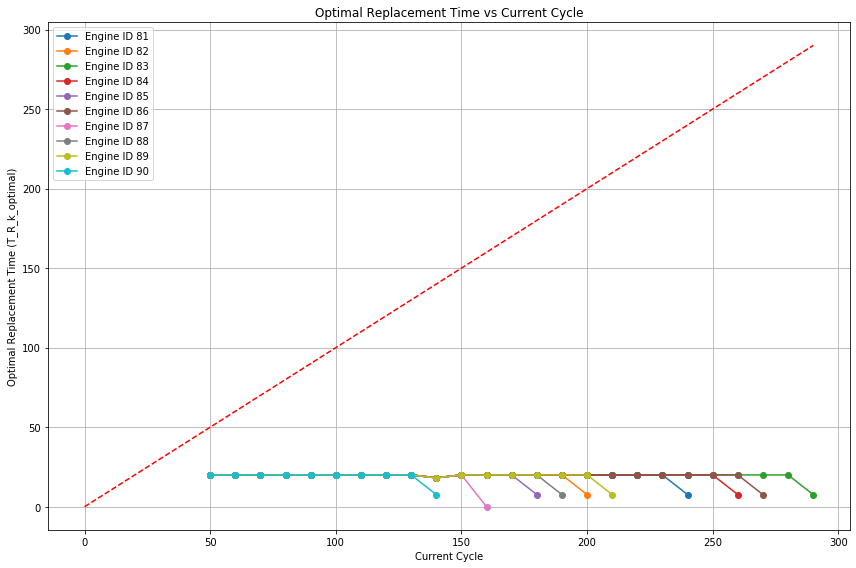

In [88]:
import matplotlib.pyplot as plt

def plot_T_R_k_optimal(T_R_k_optimal_dict, num_ids_to_plot=20):
    plt.figure(figsize=(12, 8))
    
    # Select a subset of IDs to plot
    ids_to_plot = list(T_R_k_optimal_dict.keys())[:num_ids_to_plot]
    
    max_cycle = 0
    for id in ids_to_plot:
        if T_R_k_optimal_dict[id]:  # Check if the list is not empty
            cycles, T_R_k_values = zip(*T_R_k_optimal_dict[id])
            plt.plot(cycles, T_R_k_values, marker='o', linestyle='-', label=f'Engine ID {id}')
            max_cycle = max(max_cycle, max(cycles))
        else:
            print(f"No data for Engine ID {id}")
    
    if max_cycle == 0:
        print("No valid data to plot")
        return
    
    plt.xlabel('Current Cycle')
    plt.ylabel('Optimal Replacement Time (T_R_k_optimal)')
    plt.title('Optimal Replacement Time vs Current Cycle')
    plt.legend()
    plt.grid(True)
    
    # Plot the y=x line
    #plt.plot([0, max_cycle], [0, max_cycle], 'r--', label='y=x')
    
    plt.tight_layout()
    plt.show()

# Usage remains the same
t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array, T_R_k_optimal_dict = calculate_probabilities_for_pdm_policy_3_Without_ordering(
    estimator, pdm_df, scaler, train_df, params, cols_normalize_train, sequence_cols, C_p, C_c, L, DT, C_unav, C_inv)

# Plot the T_R_k_optimal values
plot_T_R_k_optimal(T_R_k_optimal_dict)

## With Ordering

In [90]:
import numpy as np
import torch

def calculate_probabilities_for_pdm_policy_3_With_ordering(estimator, pdm_df, train_df, params, cols_normalize_train, sequence_cols, C_p, C_c, L, DT, C_unav, C_inv):
    counter = 0
    t_order_array = np.zeros(len(pdm_df['id'].unique()))
    t_LC_array = np.zeros(len(pdm_df['id'].unique()))
    costs_rep_array = np.zeros(len(pdm_df['id'].unique()))
    costs_delay_array = np.zeros(len(pdm_df['id'].unique()))
    costs_stock_array = np.zeros(len(pdm_df['id'].unique()))
    w = np.ceil(L / DT) * DT

    # Move model to CPU and set to evaluation mode
    estimator = estimator.cpu()
    estimator.eval()

    for id in pdm_df['id'].unique():
        preventive_replacement = False
        order = False

        for current_cycle in range(params['seq_length'], pdm_df[pdm_df['id'] == id].shape[0] + 1):
            if current_cycle in array_decisions:
                # Prepare data
                seq_array_test_k = prepare_sequence_data(pdm_df, scaler, id, current_cycle, params, cols_normalize_train, sequence_cols)

                # Convert to tensor (on CPU)
                seq_tensor = torch.tensor(seq_array_test_k, dtype=torch.float32)

                # Predict
                with torch.no_grad():
                    outputs = estimator(seq_tensor).squeeze()
                probabilities = torch.softmax(outputs, dim=1).numpy()

                #print(f"Engine ID: {id}, Cycle: {current_cycle}")

                # Calculate optimal replacement time
                T_R_k_optimal = find_optimal_replacement_time_for_PDM_Policy3(probabilities, C_p, C_c, current_cycle, DT)

                # Apply PDM policy 3
                if DT >= T_R_k_optimal:     
                    action = "PR"  # Preventive Replacement
                else:
                    action = "DN"  # Do Nothing

                # Ordering decision
                prob_RUL_smaller_w1 = probabilities[-1, 1] + probabilities[-1, 2]
                p_order_thres = 0.11  # Heuristic threshold for ordering
                if not order and prob_RUL_smaller_w1 >= p_order_thres:
                    #t_order_array[counter] = current_cycle + w
                    t_order_array[counter] = current_cycle 
                    order = True

                # Preventive replacement decision
                if action == "PR":
                    T_R_i = current_cycle
                    T_F_i = pdm_df[pdm_df['id'] == id]['cycle'].iloc[-1]
                    t_LC_array[counter] = min(T_R_i, T_F_i)
                    costs_rep_array[counter] = C_p if T_R_i < T_F_i else C_c
                    preventive_replacement = True
                    costs_delay_array[counter] = max(t_order_array[counter] + L - t_LC_array[counter], 0) * C_unav
                    costs_stock_array[counter] = max(t_LC_array[counter] - (t_order_array[counter] + L), 0) * C_inv
                    break

        if not preventive_replacement:
            t_LC_array[counter] = pdm_df[pdm_df['id'] == id]['cycle'].iloc[-1]
            costs_rep_array[counter] = C_c

            if not order:
                costs_delay_array[counter] = L * C_unav
                costs_stock_array[counter] = 0  # No stock cost if no order was placed
            else:
                costs_delay_array[counter] = max(t_order_array[counter] + L - t_LC_array[counter], 0) * C_unav
                costs_stock_array[counter] = max(t_LC_array[counter] - (t_order_array[counter] + L), 0) * C_inv

        counter += 1

    return t_order_array, t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array

# Usage
t_order_array, t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array = calculate_probabilities_for_pdm_policy_3_With_ordering(estimator, pdm_df,train_df, params, cols_normalize_train, sequence_cols, C_p, C_c, L,DT, C_unav, C_inv)



In [91]:
t_order_array

array([210., 180., 270., 240., 160., 250., 150., 180., 190., 130., 110.,
       320., 120., 230., 260., 310., 180., 130., 160., 160.])

In [92]:
t_LC_array

array([240., 200., 290., 260., 180., 270., 160., 190., 210., 140., 130.,
       330., 140., 250., 270., 330., 190., 130., 170., 190.])

In [93]:
costs_rep_array

array([1000.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.])

In [94]:
costs_delay_array

array([  0.,   0.,   0.,   0.,   0.,   0., 100., 100.,   0., 100.,   0.,
       100.,   0.,   0., 100.,   0., 100., 200., 100.,   0.])

In [95]:
costs_stock_array

array([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., 10.])

In [96]:
#total_cost = costs_rep_array +costs_delay_array+costs_stock_array
#total_cost

In [ ]:
# Example usage
def calculate_T_R_perfect(pdm_df, id, DT=10):
    # Retrieve the perfect failure time for the ith component
    T_F_perfect = pdm_df[pdm_df['id'] == id]['cycle'].iloc[-1]
    
    # Calculate k as the largest integer such that k * DT < T_F_perfect
    k = int(T_F_perfect // DT)  # Use floor division
    T_R_perfect = k * DT  # Calculate T_R_perfect
    
    return T_R_perfect

def calculate_decision_metric_with_ordering(costs_rep_array, costs_delay_array, costs_stock_array, t_LC_array, C_p, pdm_df):
    # Calculate the average costs and lifecycle times
    average_costs = (np.mean(costs_rep_array) + np.mean(costs_delay_array) + np.mean(costs_stock_array))
    average_t_LC_array = np.mean(t_LC_array)

    # Calculate T_R_perfect for each component and then find the average
    T_R_perfect_array = []
    for id in pdm_df['id'].unique():
        T_R_perfect = calculate_T_R_perfect(pdm_df, id, DT=10)
        T_R_perfect_array.append(T_R_perfect)

    average_T_R_perfect = np.mean(T_R_perfect_array)

    # Calculate the first part of the numerator
    numerator_part1 = average_costs / average_t_LC_array

    # Calculate the second part of the numerator
    numerator_part2 = C_p / average_T_R_perfect

    # Calculate the full numerator
    numerator = numerator_part1 - numerator_part2

    # Calculate the denominator
    denominator = C_p / average_T_R_perfect

    # Calculate the decision-oriented metric as a percentage
    #M_hat = (numerator / denominator) * 100 if denominator != 0 else 0  # Avoid division by zero
    M_hat = (numerator / denominator)

    return M_hat

def calculate_decision_metric_without_ordering(costs_rep_array,  t_LC_array, C_p, pdm_df):
    # Calculate the average costs and lifecycle times
    average_costs = np.mean(costs_rep_array)
    average_t_LC_array = np.mean(t_LC_array)

    # Calculate T_R_perfect for each component and then find the average
    T_R_perfect_array = []
    for id in pdm_df['id'].unique():
        T_R_perfect = calculate_T_R_perfect(pdm_df, id, DT=10)
        T_R_perfect_array.append(T_R_perfect)

    average_T_R_perfect = np.mean(T_R_perfect_array)

    # Calculate the first part of the numerator
    numerator_part1 = average_costs / average_t_LC_array

    # Calculate the second part of the numerator
    numerator_part2 = C_p / average_T_R_perfect

    # Calculate the full numerator
    numerator = numerator_part1 - numerator_part2

    # Calculate the denominator
    denominator = C_p / average_T_R_perfect

    # Calculate the decision-oriented metric as a percentage
    #M_hat = (numerator / denominator) * 100 if denominator != 0 else 0  # Avoid division by zero
    M_hat = (numerator / denominator)

    return M_hat

# Usage remains the same
# Range of C_p values
C_p_values = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
C_c = 1000  # Constant corrective replacement cost
M_hat_Policy1_With_ordering = []
M_hat_Policy1_Without_ordering = []

M_hat_Policy2_With_ordering = []
M_hat_Policy2_Without_ordering = []

M_hat_Policy3_With_ordering = []
M_hat_Policy3_Without_ordering = []

# Calculate M_hat for each C_p
for C_p in C_p_values:
    #Call the function to get updated arrays for policy1 with ordering  
    t_order_array, t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array = calculate_probabilities_for_pdm_policy_1_With_ordering(estimator, pdm_df,scaler, params, cols_normalize_train, sequence_cols, C_p, C_c, L,DT, C_unav, C_inv)

    # Calculate M_hat using the updated arrays
    M_hat1 = calculate_decision_metric_with_ordering(costs_rep_array, costs_delay_array, costs_stock_array, t_LC_array, C_p, pdm_df)
    M_hat_Policy1_With_ordering.append(M_hat1)
    
    
    # Call the function to get updated arrays for policy1 without ordering
    t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array, prob_RUL_smaller_DT_dict, replacement_probs_dict = calculate_probabilities_for_pdm_policy_1_Without_ordering(estimator, pdm_df,scaler, params, cols_normalize_train, sequence_cols, C_p, C_c, L,DT, C_unav, C_inv)

    # Calculate M_hat using the updated arrays
    M_hat2 = calculate_decision_metric_without_ordering(costs_rep_array,  t_LC_array, C_p, pdm_df)
    M_hat_Policy1_Without_ordering.append(M_hat2)
    
    
    
    # Call the function to get updated arrays for policy2 with ordering
    t_order_array, t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array = calculate_probabilities_for_pdm_policy_2_With_ordering(estimator, pdm_df,scaler, params, cols_normalize_train, sequence_cols, C_p, C_c, L,DT, C_unav, C_inv)
    
    # Calculate M_hat using the updated arrays
    M_hat3 = calculate_decision_metric_with_ordering(costs_rep_array, costs_delay_array, costs_stock_array, t_LC_array, C_p, pdm_df)
    M_hat_Policy2_With_ordering.append(M_hat3)
    
    
    # Call the function to get updated arrays for policy2 without ordering
    t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array, optimal_replacement_times, rul_distributions = calculate_probabilities_for_pdm_policy_2_Without_ordering(
    estimator, pdm_df, scaler, params, cols_normalize_train, sequence_cols, C_p, C_c, L, DT, C_unav, C_inv)
    
    # Calculate M_hat using the updated arrays
    M_hat4 = calculate_decision_metric_without_ordering(costs_rep_array,  t_LC_array, C_p, pdm_df)
    M_hat_Policy2_Without_ordering.append(M_hat4)
    
    
    # Call the function to get updated arrays for policy3 with ordering                   
    t_order_array, t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array = calculate_probabilities_for_pdm_policy_3_With_ordering(estimator, pdm_df,train_df, params, cols_normalize_train, sequence_cols, C_p, C_c, L,DT, C_unav, C_inv)

    # Calculate M_hat using the updated arrays
    M_hat5 = calculate_decision_metric_with_ordering(costs_rep_array, costs_delay_array, costs_stock_array, t_LC_array, C_p, pdm_df)
    M_hat_Policy3_With_ordering.append(M_hat5)
    
    # Call the function to get updated arrays for policy3 without ordering
    t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array, T_R_k_optimal_dict = calculate_probabilities_for_pdm_policy_3_Without_ordering(
    estimator, pdm_df, scaler, train_df, params, cols_normalize_train, sequence_cols, C_p, C_c, L, DT, C_unav, C_inv)

    # Calculate M_hat using the updated arrays
    M_hat6 = calculate_decision_metric_without_ordering(costs_rep_array,  t_LC_array, C_p, pdm_df)
    M_hat_Policy3_Without_ordering.append(M_hat6)
    
    
    

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate C_p/C_c ratios
C_p_C_c_ratios = C_p_values / C_c

# Plotting the results
plt.figure(figsize=(12, 8))

policies = [
    (M_hat_Policy1_With_ordering, 'Policy 1 With Ordering'),
    (M_hat_Policy1_Without_ordering, 'Policy 1 Without Ordering'),
    (M_hat_Policy2_With_ordering, 'Policy 2 With Ordering'),
    (M_hat_Policy2_Without_ordering, 'Policy 2 Without Ordering'),
    (M_hat_Policy3_With_ordering, 'Policy 3 With Ordering'),
    (M_hat_Policy3_Without_ordering, 'Policy 3 Without Ordering')
]

for data, label in policies:
    plt.plot(C_p_C_c_ratios, data, marker='o', label=label)
    print(f"{label} data: {data}")  # Print data for debugging

plt.title('Decision Metric M_hat% vs C_p/C_c Ratio')
plt.xlabel('C_p/C_c Ratio')
plt.ylabel('Decision Metric M_hat%')
plt.legend()
#plt.yscale("log")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xticks(C_p_C_c_ratios)  # Set x-ticks to the calculated ratios
plt.axhline(0, color='black', lw=0.5, ls='--')  # Add a horizontal line at y=0

# Adjust y-axis limits to ensure all data is visible
plt.ylim(bottom=max(1, plt.ylim()[0]), top=plt.ylim()[1]*1.1)

# Save the plot as an image
plt.savefig('decision_metric_plot.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
"""
from sklearn import preprocessing

counter = 0
for id in test_df['id'].unique():
    print('ID:', id)
    preventive_replacement = False
    order = False

    for current_cycle in range(test_df[test_df['id'] == id].shape[0] - params['seq_length'] + 1):

        if current_cycle in array_decisions:
            min_max_scaler = preprocessing.MinMaxScaler()
            norm_test_df = pd.DataFrame(min_max_scaler.fit_transform(test_df[test_df['id'] == id][cols_normalize_train][:params['seq_length'] + current_cycle]),
                                        columns=cols_normalize_train,
                                        index=test_df[test_df['id'] == id][:params['seq_length'] + current_cycle].index)

            join_df = test_df[test_df['id'] == id][:params['seq_length'] + current_cycle][test_df[test_df['id'] == id][:params['seq_length'] + current_cycle].columns.difference(cols_normalize_train)].join(norm_test_df)
            test_df_eval_online = join_df.reindex(columns=test_df[test_df['id'] == id][current_cycle:params['seq_length'] + current_cycle].columns)

            seq_array_test_k = test_df_eval_online[sequence_cols].values[current_cycle:params['seq_length'] + current_cycle]
            seq_array_test_k = np.asarray(seq_array_test_k).astype(np.float32).reshape(1, params['seq_length'], nb_features)

            # Convert to tensor
            seq_tensor = torch.tensor(seq_array_test_k, dtype=torch.float32).to(device)

            # Predict
            outputs = estimator(seq_tensor).squeeze()
            #print('outputs: ',outputs )
            probabilities = torch.softmax(outputs, dim=1).cpu().detach().numpy() #shape: [batch_size, sequence_length,num_classes]
            #prob_RUL_smaller_DT = probabilities[-1,2] # class2 probability for last time steps
            #prob_RUL_smaller_w1 = probabilities[-1,1] + probabilities[-1,2] # (class1+class2) for last time steps
            
            # Assuming 'probabilities' is your (1, 50, 3) tensor
            prob_RUL_smaller_w1 = probabilities[:, 1] + probabilities[:, 2]
            prob_RUL_smaller_DT = probabilities[:, 2]

            
            #print('Collective probabilities: ', probabilities)
            #print('shape of Collective probabilities: ', probabilities.shape)
            print('prob_RUL_smaller_w1:', prob_RUL_smaller_w1)
            print('prob_RUL_smaller_DT:', prob_RUL_smaller_DT)

            # Evaluate decision heuristics
            if not order:#
                # Order component
                if C_p <= ( * C_c):
                    print('prob_RUL_smaller_w1:', prob_RUL_smaller_w1)
                    print('prob_RUL_smaller_DT:', prob_RUL_smaller_DT)
                    t_order_array[counter] = params['seq_length'] + current_cycle
                    order = True
                    print('component ordering at cycle:', t_order_array[counter])
            
            # Perform preventive replacement
            if C_p <= (prob_RUL_smaller_DT * C_c):
                print('prob_RUL_smaller_DT:', prob_RUL_smaller_DT)

                t_LC_array[counter] = params['seq_length'] + current_cycle
                costs_rep_array[counter] = C_p
                print('preventive replacement informed at cycle:', t_LC_array[counter])

                preventive_replacement = True
                costs_delay_array[counter] = max(t_order_array[counter] + L - t_LC_array[counter], 0) * C_unav
                costs_stock_array[counter] = max(t_LC_array[counter] - (t_order_array[counter] + L), 0) * C_inv
                break

    if not preventive_replacement:
        t_LC_array[counter] = test_df[test_df['id'] == id]['cycle'].iloc[-1]
        print('Component failure at t:', t_LC_array[counter])
        costs_rep_array[counter] = C_c

        if not order:
            costs_delay_array[counter] = L * C_unav
        else:
            costs_delay_array[counter] = max(t_order_array[counter] + L - t_LC_array[counter], 0) * C_unav
            costs_stock_array[counter] = max(t_LC_array[counter] - (t_order_array[counter] + L), 0) * C_inv

    print('True failure:', test_df[test_df['id'] == id]['cycle'].iloc[-1])
    print('-----------------------------------------')
    counter += 1


"""

In [ ]:
costs_tot

In [ ]:
t_LC_array

In [ ]:
t_order_array

### This code calculates the expected cost per unit time using the LSTM model. It computes the mean of the total costs divided by the mean of the time to component failure (t_LC_array). This metric gives an estimate of the average cost incurred per unit time in the system, considering both maintenance and operational costs.

In [ ]:
expected_cost_LSTM = np.mean(costs_tot) / np.mean(t_LC_array)
expected_cost_LSTM

This code segment calculates the expected cost per unit time assuming perfect prognostics.
`1. Perfect Prognostics Calculation:`
> * It initializes an array `t_LC_perfect_array` to store the time of component failure for each unit in the validation dataset. This is calculated by dividing the last observed cycle number by the decision interval DT and then flooring the result to get the last decision cycle before failure.
> * The loop iterates over each unique ID in the validation dataset, calculates the time of component failure for each unit, and stores it in
`t_LC_perfect_array`.<br>
> * `math.floor()` is used to round down the result to the nearest multiple of `DT`.
> * Finally, the loop increments the counter for each unit.<br>

`2. Cost Calculation:`
> * `costs_perfect_array` is initialized with a value of `C_p`, representing the cost of preventive replacements. In a perfect scenario, only preventive replacements are made.
> * This array holds the same cost value for each unit in the validation dataset.

`3. Expected Cost Calculation:`
> * `expected_cost_perfect` is calculated by taking the mean of `costs_perfect_array` and dividing it by the mean of `t_LC_perfect_array`.
> * This calculation provides an estimate of the average cost per unit time assuming perfect prognostics, where components are replaced preventively at regular intervals.









In [ ]:
# Perfect prognostics
import math
t_LC_perfect_array  = np.zeros(10)
DT=10
counter=0
for id in test_df['id'].unique():
    t_LC_perfect_array[counter] = math.floor(test_df[test_df['id']==id]['cycle'].iloc[-1] /DT) * DT
    counter+=1

costs_perfect_array = np.ones(10)*C_p # a perfect policy will only lead to preventive replacements

expected_cost_perfect = np.mean(costs_perfect_array)/np.mean(t_LC_perfect_array)
expected_cost_perfect


In [ ]:
t_LC_perfect_array

In [ ]:
# evaluation of the metric defined in the paper
M = (expected_cost_LSTM - expected_cost_perfect) / expected_cost_perfect
M # it obtains a very small value

In [ ]:
M*100